# Setup


In [1]:
pip install numpy==1.23.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install scikit-learn==0.24.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: Could not build wheels for gensim, which is required to install pyproject.toml-based projects


In [4]:
import sklearn.cluster as skc
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, leaves_list

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import gensim
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import sklearn
print(sklearn.__version__)

0.24.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/Shareddrives/UWMED_AI/colab/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/(PENDING_DELETE_on_8-29-2023)--UWMED_AI/colab


In [7]:
# Load BioWord2Vec vectors

word2vec = gensim.models.KeyedVectors.load_word2vec_format(
     'BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True, limit=50000000)

## Data Prep


In [8]:
data = pd.read_pickle('rad_diag_onc_EBCA_R.pkl')
data.shape

(9646, 48)

In [9]:
data.head()

APPLICATION_ID ACTIVITY ADMINISTERING_IC  APPLICATION_TYPE ARRA_FUNDED  \
9          2089575      R01               CA               5.0         NaN   
10         2089705      R01               CA               5.0         NaN   
14         2098040      R55               CA               1.0         NaN   
32         2084460      R01               CA               5.0         NaN   
33         2087011      R01               CA               5.0         NaN   

      AWARD_NOTICE_DATE BUDGET_START  BUDGET_END CFDA_CODE CORE_PROJECT_NUM  \
9   1992-05-12T00:00:00   06/01/1992  05/31/1996     399.0      R01CA038515   
10  1992-03-20T00:00:00   04/01/1992  03/31/1995     393.0      R01CA039045   
14  1992-09-24T00:00:00   09/30/1992  09/29/1995     395.0      R55CA057304   
32  1992-12-01T00:00:00   12/01/1992  11/30/1994     395.0      R01CA003353   
33  1992-11-30T00:00:00   12/01/1992  11/30/1994     395.0      R01CA022188   

    ... SUFFIX SUPPORT_YEAR TOTAL_COST TOTAL_COST_SUB_PROJECT  \
9   ...    NaN          7.0        NaN                    NaN   
10  ...    NaN          6.0        NaN                    NaN   
14  ...    NaN          1.0        NaN                    NaN   
32  ...    NaN         36.0        NaN                    NaN   
33  ...    NaN         14.0        NaN                    NaN   

    FUNDING_MECHANISM FUNDING_Ics DIRECT_COST_AMT INDIRECT_COST_AMT  \
9                 NaN         NaN             NaN               NaN   
10                NaN         NaN             NaN               NaN   
14                NaN         NaN             NaN               NaN   
32                NaN         NaN             NaN               NaN   
33                NaN         NaN             NaN               NaN   

   ORG_IPF_CODE                                           Abstract  
9           NaN  This is a proposal for continuation of R01-CA3...  
10          NaN  This program will use the recently developed m...  
14          NaN  This is a Shannon Award providing partial supp...  
32          NaN  The long term objectives of this plan are the ...  
33          NaN  The chromatin/DNA topology enzymes [i.e., poly...  

[5 rows x 48 columns]

In [10]:
data.keys()

Index(['APPLICATION_ID', 'ACTIVITY', 'ADMINISTERING_IC', 'APPLICATION_TYPE',
       'ARRA_FUNDED', 'AWARD_NOTICE_DATE', 'BUDGET_START', 'BUDGET_END',
       'CFDA_CODE', 'CORE_PROJECT_NUM', 'ED_INST_TYPE', 'FOA_NUMBER',
       'FULL_PROJECT_NUM', 'FUNDING_ICs', 'FY', 'IC_NAME', 'NIH_SPENDING_CATS',
       'ORG_CITY', 'ORG_COUNTRY', 'ORG_DEPT', 'ORG_DISTRICT', 'ORG_DUNS',
       'ORG_FIPS', 'ORG_NAME', 'ORG_STATE', 'ORG_ZIPCODE', 'PHR', 'PI_IDS',
       'PI_NAMEs', 'PROGRAM_OFFICER_NAME', 'PROJECT_START', 'PROJECT_END',
       'PROJECT_TERMS', 'PROJECT_TITLE', 'SERIAL_NUMBER', 'STUDY_SECTION',
       'STUDY_SECTION_NAME', 'SUBPROJECT_ID', 'SUFFIX', 'SUPPORT_YEAR',
       'TOTAL_COST', 'TOTAL_COST_SUB_PROJECT', 'FUNDING_MECHANISM',
       'FUNDING_Ics', 'DIRECT_COST_AMT', 'INDIRECT_COST_AMT', 'ORG_IPF_CODE',
       'Abstract'],
      dtype='object')

In [11]:
data = data[data['Abstract'].notna()]
data = data[data['ADMINISTERING_IC'] == 'CA']
data = data[data['FY'] >= 2000]
data = data[data['FY'] != 2021]
data.reset_index(drop=True, inplace=True)

data.shape

(5876, 48)

In [12]:
mystop = ['aim', 'aims', 'description', 'provided', 'applicant', 'project', 'overall', 'summary', 'abstract', 'goal', "'s",
            'summary/abstract', 'proposals', 'subproject', 'objective', 'results','methods','conclusion','goal','study','by',
            'objective', 'public', 'health', 'relevance', 'common', '(', ')', 
           ':', '.', ',', 'those', 'often', 'same', 'via', 'taken', 'although', 'versus', 'following', 
           'instead', 'another',
           'also', 'non', 'may', 'thus', 'could', 'therefore', 'without', 'even', 'much', 'among', 'co', 'yet', 'still', 'ex',
           'toward', 'hence', 'around', 'beyond', 'almost', 'outside', 'might', 'inside', 'etc', 'ever', 'whereby', 'intra', 
           'like', 'ii', 'iii', 'unreadable']
stop = nltk.corpus.stopwords.words('english') + list(string.punctuation) + mystop

clean_text = []
tokenized_text = []

len_threshold = 50

for i, ab in enumerate(data['Abstract']):
  ab = ab.replace('\\xa0', ' ')
  ab = ab.replace('\\xad', '')
  clean = word_tokenize(ab.lower())
  if len(clean) < len_threshold:
    data = data[data['Abstract'] != ab]
  else:
    clean = [tok for tok in clean if tok not in stop]
    clean_text.append(' '.join(clean))
    tokenized_text.append(clean)
data['Tokenized_Text'] = tokenized_text
data['Clean_Text'] = clean_text

In [13]:
num_Vec = TfidfVectorizer()
num_Vec.fit_transform(data['Clean_Text'])
num = [tok for tok in num_Vec.get_feature_names() if tok.isnumeric()]

In [14]:
vectorizer = TfidfVectorizer(stop_words = stop+num, min_df=50)
tfidf = vectorizer.fit_transform(data['Clean_Text']).toarray()

In [15]:
vocab_size = len(vectorizer.vocabulary_)
index_to_word = {}
for key in vectorizer.vocabulary_:
    index_to_word[vectorizer.vocabulary_[key]] = key

In [16]:
print('Vocab size:', vocab_size)

Vocab size: 2779


In [17]:
weighted_embedding = []
features = []

for grant in tfidf:
    total = np.zeros((1,200))
    features_temp = []

    for weight_ith in range(vocab_size):
        weight = grant[weight_ith]
        if weight > 0 and index_to_word[weight_ith] in word2vec.index_to_key:
            embedding = word2vec[index_to_word[weight_ith]]
            features_temp.append(np.linalg.norm(embedding))
            total += weight*embedding

    features.append(features_temp)
    weighted_embedding.append(np.squeeze(total))

del word2vec

## Clustering Algorithm

In [18]:
## Clustering Method: use agglom centroids as itial for KM

def get_init(n_clusters, weighted_embedding):
  clusters = skc.AgglomerativeClustering(n_clusters = n_clusters).fit_predict(weighted_embedding)
  
  # Get centroids
  centroids = []
  for i in range(n_clusters):
    tmp = []
    for index, cl in enumerate(clusters):
      if cl == i:
        tmp.append(weighted_embedding[index])
    centroids.append(np.mean(tmp, 0))
  centroids = np.array(centroids)
  return centroids


def combo_cluster_1(n_clusters, init, weighted_embedding, return_scores = False, return_model = False):
  
  model = skc.KMeans(n_clusters=n_clusters, init=init, n_init=1, random_state=0)
  model = model.fit(weighted_embedding)
  clusters = model.predict(weighted_embedding)
  
  if return_scores:
    inert = model.inertia_
    sil = metrics.silhouette_score(weighted_embedding, clusters)
    return [inert, sil]
  if return_model:
    return clusters, model
  else:
    return clusters

# Statistics

In [19]:
vocab = []
for row in data["Tokenized_Text"]:
    vocab += row

print(len(np.unique(vocab)))

25589


Text(0.5, 0, 'Number of Tokens')

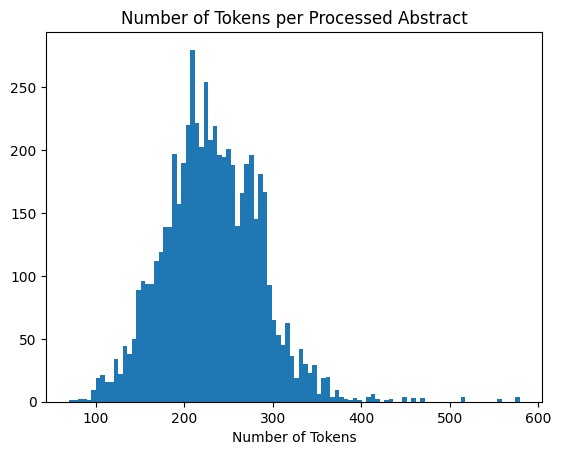

In [20]:
# Document Lengths

lens = []
for row in data['Tokenized_Text']:
  lens.append(len(row))
plt.hist(lens, bins=100)
plt.title('Number of Tokens per Processed Abstract')
plt.xlabel('Number of Tokens')

In [21]:
labels, counts = np.unique(data['ACTIVITY'], return_counts=True)
print(labels)
print(counts)

['R00' 'R01' 'R03' 'R13' 'R21' 'R24' 'R29' 'R33' 'R35' 'R37' 'R38' 'R50'
 'R56' 'RC1']
[  39 4647   45   37  802   50   46   93   36   49    1   16    5    8]


# Clustering

In [22]:
n_clusters = 15
init = get_init(n_clusters, weighted_embedding)
clusters15, kmeans15 = combo_cluster_1(n_clusters, init, weighted_embedding, return_model=True)

n_clusters = 60
init = get_init(n_clusters, weighted_embedding)
clusters60, kmeans60 = combo_cluster_1(n_clusters, init, weighted_embedding, return_model=True)

In [23]:
data['Cluster15'] = clusters15
data['Cluster60'] = clusters60

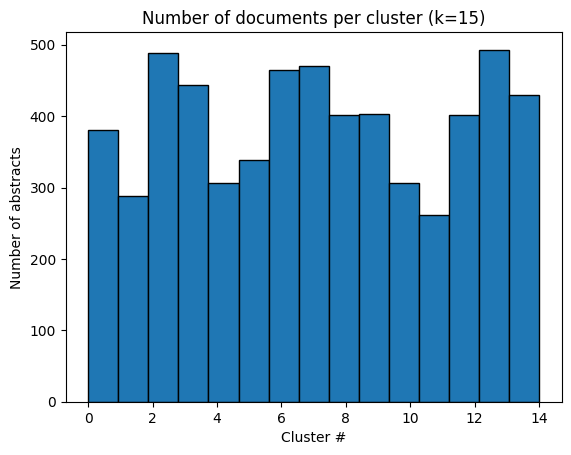

In [24]:
plt.hist(clusters15, bins=15, ec='black')
plt.title('Number of documents per cluster (k=15)')
plt.xlabel('Cluster #')
plt.ylabel('Number of abstracts')
plt.show()

Text(0, 0.5, 'Number of abstracts')

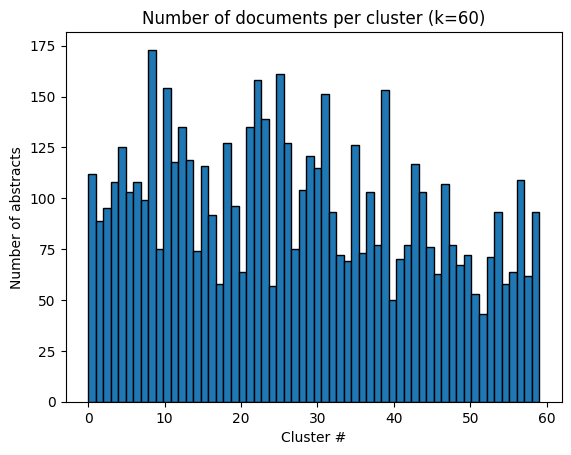

In [25]:
plt.hist(clusters60, bins=60, ec='black')
plt.title('Number of documents per cluster (k=60)')
plt.xlabel('Cluster #')
plt.ylabel('Number of abstracts')

# Cluster name

In [26]:
cluster_name_dendrogram = ['Radiotherapy & CBCT Technology',
                           'DNA damage & repair',
                           'Novel imaging systems',
                           'Breast/prostate cancer diagnosis',
                           'Targeted cancer therapies',
                           'Clinical imaging (non-functional)',
                           'Clinical Imaging (functional)',
                           'Clinical Radiotherapy',
                           'Molecular pathways',
                           'Imaging in cancer therapy',
                           'Cancer genetics',
                           'Molecular Therapies',
                           'Automated detection',
                           'Molecular/Clinical Imaging',
                           'Stress & therapeutic resistance']

In [27]:
cluster_name_dendrogram_60 = [
'Radiotherapy targeting technology',
'Genetic and immune targeting resistance mechanisms',
'Biomarkers for treatment response',
'Ablation, oxygenation, novel MRI methods',
'Imaging biomarkers for diagnosis and treatment response',
'Image guided therapies',
'Drug therapy mechanisms and strategy',
'Radiopharmaceuticals',
'Functional imaging for radiation response',
'Cancer control, conferences for advocacy',
'Image-based screening',
'Apoptosis and tumor suppressors',
'Radiosensitization, radioprotection',
'Improving PET/SPECT accuracy',
'Radiation-matter damage',
'MRI imaging',
'DNA damage repair pathways',
'DNA damage repair proteins',
'MR/US tumor detection and characterization',
'Tumorigenesis and metastasis mechanisms',
'Epigenetics',
'Radiation treatment planning and dosimetry',
'Molecular modulation of radiation',
'Apoptosis and stress response',
'RAS pathway signaling',
'PET and CT technology for acquisiton and reconstruction',
'PET and CT technology for treatment planning',
'Signaling pathways as therapeutic target',
'PET for treatment response and surveillance',
'Organ-specific ablation and functional imaging',
'Metastatic microenvironment signaling and imaging',
'Oncoprotein signaling',
'Interventional imaging',
'Metabolic imaging',
'Animal imaging, resource development',
'Improving performance of breast cancer CAD',
'Gene therapy, reporter genes',
'Radioimmunotherapy, conjugate molecular therapy',
'p53 regulation',
'Advanced MRI methods',
'DNA mutagenesis',
'Advanced imaging hardware technology',
'Small molecular therapy',
'Image-guided targeted drug delivery',
'Hypoxia and metabolism',
'Respiratory motion management for imaging and therapy',
'Molecular imaging',
'DNA damage response - double strand break',
'DNA damage response - non-DSB',
'Informatics software for treatment decision support',
'Prognostic and predictive molecular biomarkers',
'Nuclear and optical imaging agents',
'Computer aided detection and diagnosis in thorax',
'Novel PET imaging agents',
'Novel contrast agents',
'Nanoparticle imaging and therapy',
'Image-based breast cancer screening and risk prediction',
'Cellular stress response',
'Mammography and tomosynthesis',
'Cellular oxidative stress'
]

# Results

## Trajectory


In [28]:
# Binning function
year_range = np.unique(data['FY'])

def binning(data, bin_size):
  data = data[len(data) % bin_size:]
  output = []
  i = 0 
  while i < len(data):
    tmp = []
    for b in range(bin_size):
      tmp.append(data[i+b])
    output.append(np.mean(tmp))
    i = i + bin_size
  return output

binning(year_range, 3)

[2001.0, 2004.0, 2007.0, 2010.0, 2013.0, 2016.0, 2019.0]

In [29]:
xticks = [2001, 2004, 2007, 2010, 2013, 2016, 2019]

In [30]:
def get_funds(clusters):
  n_clusters = len(np.unique(clusters))
  
  funds = []
  for n in range(n_clusters):
    indices = np.squeeze(np.where(clusters == n))
    funds_yr = []
    for fy in year_range:
      subset = data[data['FY'] == fy]
      funds_tmp = 0
      
      for index in indices:
        if index in subset.index.values:
          funds_tmp = funds_tmp +  subset.loc[index, 'TOTAL_COST'] 
      funds_yr.append(funds_tmp)
    funds.append(funds_yr)

  funds = np.array(funds).transpose()
  return funds

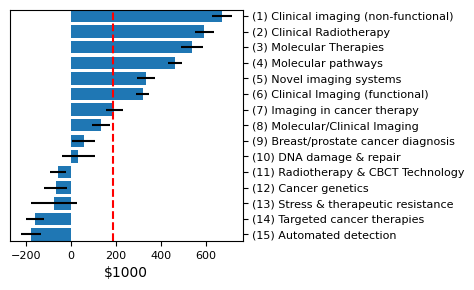

In [31]:
fig = plt.figure(figsize=(3,3))

funds15 = get_funds(clusters15)
n_clusters = len(funds15[0])

slopes = []
errors = []

for i in range(n_clusters):
    out = stats.linregress(year_range, funds15[:, i] / 1000)
    slopes.append(out[0])
    errors.append(out[4])

rename = []
name = cluster_name_dendrogram

order15 = np.argsort(slopes)

for i in range(n_clusters):
    rename.append('('+ str(n_clusters-i) + ') ' + name[order15[i]])

avg = np.mean(slopes) * np.ones([n_clusters, 1])


plt.barh(np.array(rename), np.array(slopes)[order15], xerr = errors)
plt.axvline(x=np.mean(slopes), color="red", linestyle="--")
plt.xlabel('$1000', fontsize=10)

plt.tick_params(left=False, labelleft=False, right=True, labelright=True, rotation=0, labelsize=8)
plt.margins(y=0)

plt.savefig("Growth_rate_15h.png", bbox_inches = "tight")

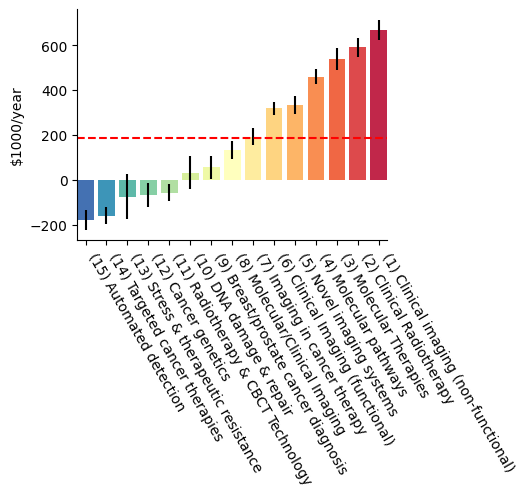

In [32]:
palette = sns.color_palette('Spectral', 15)

fig, ax = plt.subplots(figsize=(4,3))
plt.bar(np.array(rename), np.array(slopes)[order15], yerr = errors, color=palette.as_hex()[::-1])
plt.axhline(y=np.mean(slopes), color="red", linestyle="--")
plt.xticks(rotation=-60, ha="left", va="top")
plt.ylabel('$1000/year', fontsize=10)
plt.margins(x=0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig("Growth_rate_15v.png", bbox_inches = "tight")
plt.show()

In [33]:
slopes15 = np.array(slopes)[order15]*1000
slopes15 = slopes15[::-1]
rename15 = rename[::-1]
order15 = order15[::-1]

In [34]:
for cluster_name, start, end, color in zip(np.array(rename15), funds15[0][order15], funds15[-1][order15], palette.as_hex()):
      print(cluster_name, " "*(70-len(cluster_name)), 
            start, " "*(10-len(str(start))), "(" + str(round(500-start/40000)) + ") ||", 
            end, " "*(10-len(str(end))), "(" + str(round(500-end/40000)) + ") || Color=" + str(color))

(1) Clinical imaging (non-functional)                                   439031.0    (489) || 16357158.0  (91) || Color=#c1274a
(2) Clinical Radiotherapy                                               1720918.0   (457) || 14639796.0  (134) || Color=#dd4a4c
(3) Molecular Therapies                                                 106700.0    (497) || 11119073.0  (222) || Color=#f06744
(4) Molecular pathways                                                  2402753.0   (440) || 10746072.0  (231) || Color=#f98e52
(5) Novel imaging systems                                               5193170.0   (370) || 12965039.0  (176) || Color=#fdb567
(6) Clinical Imaging (functional)                                       2875637.0   (428) || 11429945.0  (214) || Color=#fed481
(7) Imaging in cancer therapy                                           4026889.0   (399) || 7393703.0   (315) || Color=#feec9f
(8) Molecular/Clinical Imaging                                          5483328.0   (363) || 9757960.0   

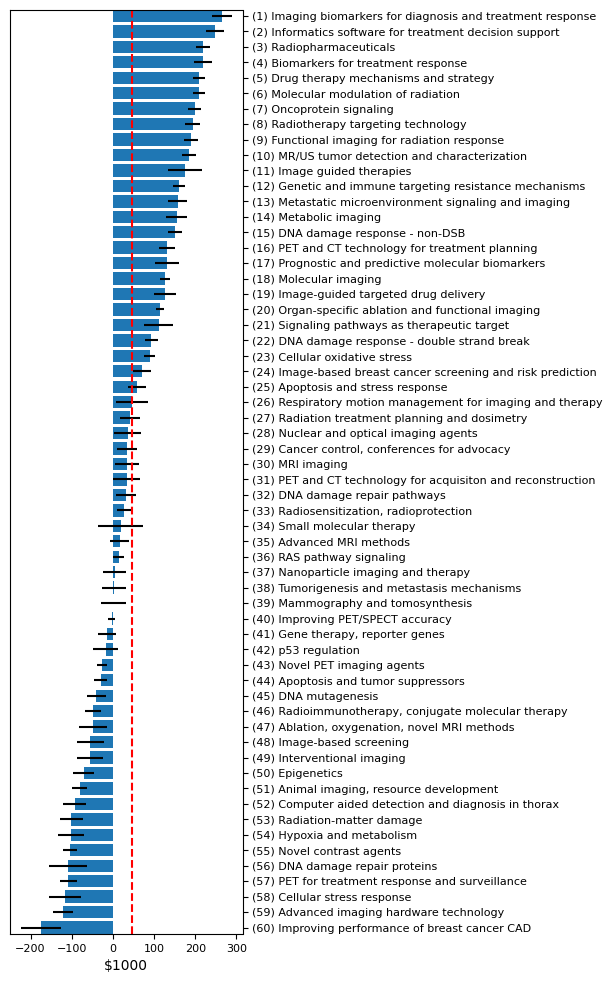

In [35]:
fig = plt.figure(figsize=(3,12))

funds60 = get_funds(clusters60)
n_clusters = len(funds60[0])

slopes = []
errors = []

for i in range(n_clusters):
    out = stats.linregress(year_range, funds60[:, i] / 1000)
    slopes.append(out[0])
    errors.append(out[4])

rename = []
name = cluster_name_dendrogram_60

order60 = np.argsort(slopes)

for i in range(n_clusters):
    rename.append('('+ str(n_clusters-i) + ') ' + name[order60[i]])

avg = np.mean(slopes) * np.ones([n_clusters, 1])

plt.barh(np.array(rename), np.array(slopes)[order60], xerr = errors)
plt.axvline(x=np.mean(slopes), color="red", linestyle="--")
plt.xlabel('$1000', fontsize=10)

plt.tick_params(left=False, labelleft=False, right=True, labelright=True, rotation=0, labelsize=8)
plt.margins(y=0)
plt.savefig("Growth_rate_60h.png", bbox_inches = "tight")

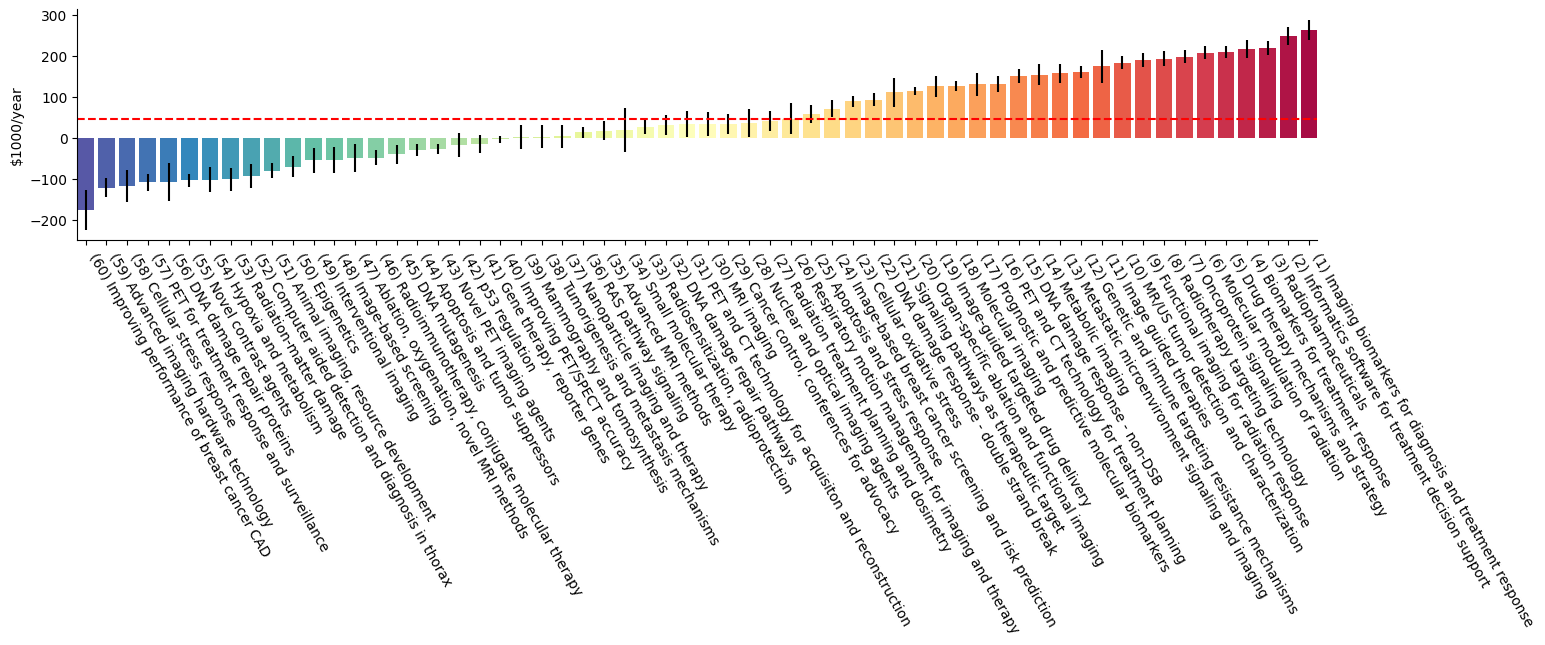

In [36]:
palette = sns.color_palette('Spectral', 60)

fig, ax = plt.subplots(figsize=(16,3))
plt.bar(np.array(rename), np.array(slopes)[order60], yerr = errors, color=palette.as_hex()[::-1])
plt.axhline(y=np.mean(slopes), color="red", linestyle="--")
plt.xticks(rotation=-60, ha="left", va="top")
plt.ylabel('$1000/year', fontsize=10)
plt.margins(x=0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig("Growth_rate_60v.png", bbox_inches = "tight")
plt.show()

In [37]:
slopes60 = np.array(slopes)[order60]*1000
slopes60 = slopes60[::-1]
rename60 = rename[::-1]
order60 = order60[::-1]

for cluster_name, start, end, color in zip(np.array(rename60), funds60[0][order60], funds60[-1][order60], palette.as_hex()):
      print(cluster_name, " "*(70-len(cluster_name)), 
            start, " "*(10-len(str(start))), "(" + str(round(500-start/40000)) + ") ||", 
            end, " "*(10-len(str(end))), "(" + str(round(500-end/40000)) + ") || Color=" + str(color))

(1) Imaging biomarkers for diagnosis and treatment response             439031.0    (489) || 7786678.0   (305) || Color=#a70b44
(2) Informatics software for treatment decision support                 0.0         (500) || 3808546.0   (405) || Color=#af1446
(3) Radiopharmaceuticals                                                0.0         (500) || 4315085.0   (392) || Color=#b81e48
(4) Biomarkers for treatment response                                   412158.0    (490) || 6067005.0   (348) || Color=#c1274a
(5) Drug therapy mechanisms and strategy                                0.0         (500) || 3074301.0   (423) || Color=#c9314c
(6) Molecular modulation of radiation                                   1218488.0   (470) || 5780189.0   (355) || Color=#d43d4f
(7) Oncoprotein signaling                                               726025.0    (482) || 4223408.0   (394) || Color=#d9444d
(8) Radiotherapy targeting technology                                   210225.0    (495) || 6587911.0  

In [38]:
clusters15_remap = {}

for initial, final in zip(order15, rename15):
    clusters15_remap[initial]=final

clusters15_remap

{5: '(1) Clinical imaging (non-functional)',
 7: '(2) Clinical Radiotherapy',
 11: '(3) Molecular Therapies',
 8: '(4) Molecular pathways',
 2: '(5) Novel imaging systems',
 6: '(6) Clinical Imaging (functional)',
 9: '(7) Imaging in cancer therapy',
 13: '(8) Molecular/Clinical Imaging',
 3: '(9) Breast/prostate cancer diagnosis',
 1: '(10) DNA damage & repair',
 0: '(11) Radiotherapy & CBCT Technology',
 10: '(12) Cancer genetics',
 14: '(13) Stress & therapeutic resistance',
 4: '(14) Targeted cancer therapies',
 12: '(15) Automated detection'}

In [39]:
clusters60_remap = {}

for initial, final in zip(order60, rename60):
    clusters60_remap[initial]=final

clusters60_remap

{4: '(1) Imaging biomarkers for diagnosis and treatment response',
 49: '(2) Informatics software for treatment decision support',
 7: '(3) Radiopharmaceuticals',
 2: '(4) Biomarkers for treatment response',
 6: '(5) Drug therapy mechanisms and strategy',
 22: '(6) Molecular modulation of radiation',
 31: '(7) Oncoprotein signaling',
 0: '(8) Radiotherapy targeting technology',
 8: '(9) Functional imaging for radiation response',
 18: '(10) MR/US tumor detection and characterization',
 5: '(11) Image guided therapies',
 1: '(12) Genetic and immune targeting resistance mechanisms',
 30: '(13) Metastatic microenvironment signaling and imaging',
 33: '(14) Metabolic imaging',
 48: '(15) DNA damage response - non-DSB',
 26: '(16) PET and CT technology for treatment planning',
 50: '(17) Prognostic and predictive molecular biomarkers',
 46: '(18) Molecular imaging',
 43: '(19) Image-guided targeted drug delivery',
 29: '(20) Organ-specific ablation and functional imaging',
 27: '(21) Signal

## Emerging and disappearing funding topics

In [40]:
# Emerging
print('New funding topics:\n')

funds60_T = funds60.transpose()
for i_f in range(len(funds60_T)):
    if funds60_T[order60[i_f]][0] == 0:
        for i_year in range(len(funds60_T[order60[i_f]])):
            if funds60_T[order60[i_f]][i_year] > 0:
                year = 2000 + i_year
                break

        print(cluster_name_dendrogram_60[order60[i_f]], ': Starting in FY', year)

New funding topics:

Informatics software for treatment decision support : Starting in FY 2004
Radiopharmaceuticals : Starting in FY 2006
Drug therapy mechanisms and strategy : Starting in FY 2001
Image guided therapies : Starting in FY 2001
Genetic and immune targeting resistance mechanisms : Starting in FY 2003
Metabolic imaging : Starting in FY 2005
Image-guided targeted drug delivery : Starting in FY 2003


In [41]:
# Disappearing

print('Disappearing funding topics:\n')

for i_f in range(len(funds60_T)):
    if funds60_T[order60[i_f]][-1] == 0:
        for i_year in range(len(funds60_T[order60[i_f]])):
            if funds60_T[order60[i_f]][i_year] == 0:
                year = 2000 + i_year
                break

        print(cluster_name_dendrogram_60[order60[i_f]], ': After FY', year-1)

Disappearing funding topics:

DNA mutagenesis : After FY 2018
Epigenetics : After FY 2016
DNA damage repair proteins : After FY 2010
Improving performance of breast cancer CAD : After FY 2015


## Confusion plots

In [42]:
X_embedded = TSNE(random_state=0).fit_transform(weighted_embedding)

In [43]:
cost = np.array(data['TOTAL_COST'])
cost = np.expand_dims(cost, axis=1)
cost.shape

(5874, 1)

In [44]:
df = pd.DataFrame(columns = ['x', 'y', 'Total Cost', 'Growth rate 15', 'Growth rate 60'])

In [45]:
X_embedded[:,0]

array([-26.234068, -13.34262 ,  38.399864, ...,  31.696383,  24.540081,
        82.170685], dtype=float32)

In [46]:
df['x'] = X_embedded[:,0]
df['y'] = X_embedded[:,1]
df['Total Cost'] = np.array(data['TOTAL_COST'])
df['Growth rate 15'] = [slopes15[c] for c in clusters15]
df['Growth rate 60'] = [slopes60[c] for c in clusters60]
df.head()

x           y  Total Cost  Growth rate 15  Growth rate 60
0 -26.234068    1.104425    305122.0    33115.576623    33927.181818
1 -13.342620   68.996613    248382.0  -178090.466234  -175622.631169
2  38.399864   -2.512897    517242.0  -158854.333766  -103693.623377
3 -16.454144   35.834507    240438.0   135533.771429   157176.450649
4 -21.017550  100.830833    277200.0  -178090.466234   111125.744156

In [47]:
df_xpos = df[df['x'] >= 0]
df_xneg = df[df['x'] < 0]

# Top right
top_right_tsne = df_xpos[df_xpos['y'] >= 0]
top_left_tsne = df_xneg[df_xneg['y'] >= 0]
bottom_right_tsne = df_xpos[df_xpos['y'] < 0]
bottom_left_tsne = df_xneg[df_xneg['y'] < 0]

cost_df = pd.DataFrame(columns = ['Number of grants', 'Total Cost', 'Growth rate 15', 'Growth rate 60'],
                       index = ['Top right', 'Top left', 'Bottom right', 'Bottom left',
                                'Top', 'Bottom', 'Right', 'Left'])

cost_df.loc['Top right'] = [top_right_tsne.shape[0], np.mean(top_right_tsne['Total Cost']),
                            np.mean(top_right_tsne['Growth rate 15']), np.mean(top_right_tsne['Growth rate 60'])]
cost_df.loc['Top left'] = [top_left_tsne.shape[0], np.mean(top_left_tsne['Total Cost']),
                           np.mean(top_left_tsne['Growth rate 15']), np.mean(top_left_tsne['Growth rate 60'])]
cost_df.loc['Bottom right'] = [bottom_right_tsne.shape[0], np.mean(bottom_right_tsne['Total Cost']),
                               np.mean(bottom_right_tsne['Growth rate 15']), np.mean(bottom_right_tsne['Growth rate 60'])]
cost_df.loc['Bottom left'] = [bottom_left_tsne.shape[0], np.mean(bottom_left_tsne['Total Cost']),
                              np.mean(bottom_left_tsne['Growth rate 15']), np.mean(bottom_left_tsne['Growth rate 60'])]

n_top = top_right_tsne.shape[0] + top_left_tsne.shape[0]
cost_df.loc['Top'] = [n_top, 
                      (sum(top_right_tsne['Total Cost']) + sum(top_left_tsne['Total Cost']))/n_top,
                      (sum(top_right_tsne['Growth rate 15']) + sum(top_left_tsne['Growth rate 15']))/n_top,
                      (sum(top_right_tsne['Growth rate 60']) + sum(top_left_tsne['Growth rate 60']))/n_top]

n_bottom = bottom_right_tsne.shape[0] + bottom_left_tsne.shape[0]
cost_df.loc['Bottom'] = [n_bottom, 
                         (sum(bottom_right_tsne['Total Cost']) + sum(bottom_left_tsne['Total Cost']))/n_bottom,
                         (sum(bottom_right_tsne['Growth rate 15']) + sum(bottom_left_tsne['Growth rate 15']))/n_bottom,
                         (sum(bottom_right_tsne['Growth rate 60']) + sum(bottom_left_tsne['Growth rate 60']))/n_bottom] 

cost_df.loc['Right'] = [df_xpos.shape[0], np.mean(df_xpos['Total Cost']),
                        np.mean(df_xpos['Growth rate 15']), np.mean(df_xpos['Growth rate 60'])]

cost_df.loc['Left'] = [df_xneg.shape[0], np.mean(df_xneg['Total Cost']),
                        np.mean(df_xneg['Growth rate 15']), np.mean(df_xneg['Growth rate 60'])]                         
cost_df

Number of grants     Total Cost Growth rate 15 Growth rate 60
Top right                1594  303078.809285  155337.302962   31676.602838
Top left                 1308  301111.041284    3170.316607    51019.70493
Bottom right             1366  365964.656662  261870.567781  102890.961637
Bottom left              1606  333694.759651  288890.032218   63209.372062
Top                      2902  302191.889731   86752.045156     40394.9962
Bottom                   2972  348526.751346  276471.260878   81447.949235
Right                    2960  332099.778041  204500.965037   64541.067067
Left                     2914  319068.986273  160639.727476   57737.826211

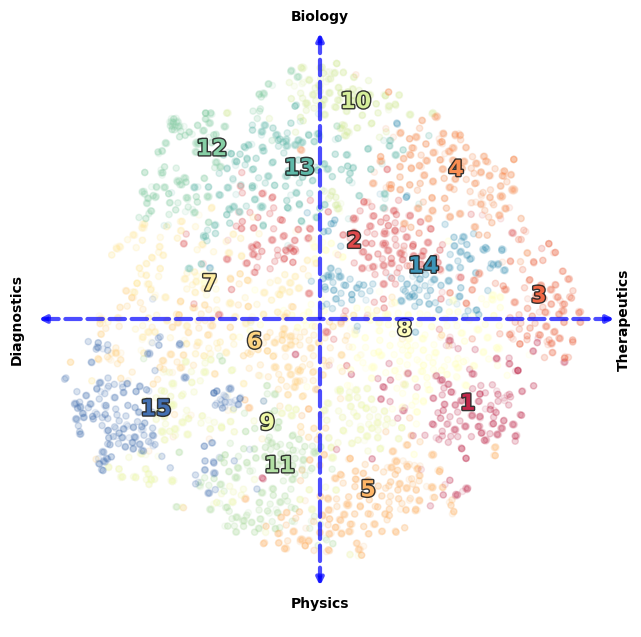

In [48]:
palette = sns.color_palette('Spectral', 15)

plt.figure(figsize=(8,8))
for i in range(15):
    # plot all datapoints with algo-assigned cluster number. However this is different from the re-assigned cluster number based on growth rate
    rank = int(re.search("(?<=\()(.*?)(?=\))", clusters15_remap[i]).group(1)) - 1
    col = [palette[rank]]*len(X_embedded[clusters15 == i, 0])
    plt.scatter(X_embedded[clusters15 == i, 0], X_embedded[clusters15 == i, 1], c=col, s=20, alpha=0.1)
    plt.text(np.mean(X_embedded[clusters15 == i, 0]), np.mean(X_embedded[clusters15 == i, 1]),
             str(rank+1), fontsize=16, fontweight='bold', c=palette[rank], ma='center',
             path_effects=[pe.withStroke(linewidth=2, foreground='k', alpha=0.8)])
    

plt.axis('off')
plt.xlim(-120,120)
plt.ylim(-160,160)

plt.annotate('', xy=(115, 0), xytext=(-110, 0),
             arrowprops=dict(arrowstyle= '<|-|>', color='blue', lw=3, ls='--', alpha=0.7))
plt.annotate('Diagnostics', xy=(-120, 0), va='center', weight='bold', rotation='vertical')
plt.annotate('Therapeutics', xy=(115, 0), va='center', weight='bold', rotation='vertical')

plt.annotate('', xy=(0, -140), xytext=(0, 150),
             arrowprops=dict(arrowstyle= '<|-|>', color='blue', lw=3, ls='--', alpha=0.7))
plt.annotate('Physics', xy=(0, -150), ha='center', weight='bold')
plt.annotate('Biology', xy=(0, 155), ha='center', weight='bold')

plt.savefig("TSNE15.png", bbox_inches = "tight")
plt.show()

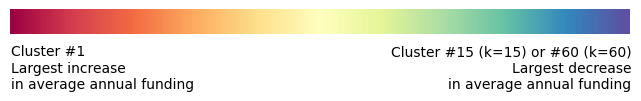

In [49]:
plt.figure(figsize=(8,2))
color_map = sns.color_palette('Spectral', 15, as_cmap=True)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect=5, cmap=color_map)
plt.axis('off')
plt.text(0,6, 'Cluster #1\nLargest increase \nin average annual funding')
plt.text(256,6, 'Cluster #15 (k=15) or #60 (k=60)\nLargest decrease\nin average annual funding', ha='right')
plt.savefig("color_scheme.png", bbox_inches = "tight")
plt.show()

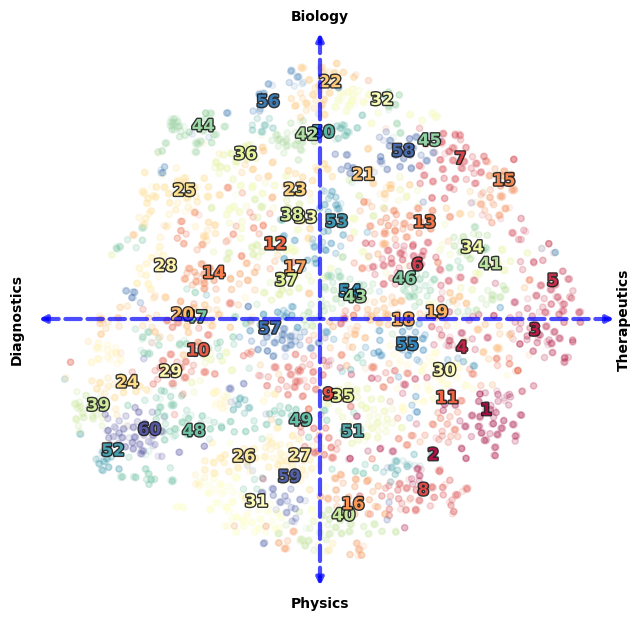

In [50]:
palette = sns.color_palette('Spectral', 60)

plt.figure(figsize=(8,8))
for i in range(60):
    # plot all datapoints with algo-assigned cluster number. However this is different from the re-assigned cluster number based on growth rate
    rank = int(re.search("(?<=\()(.*?)(?=\))", clusters60_remap[i]).group(1)) - 1
    col = [palette[rank]]*len(X_embedded[clusters60 == i, 0])
    plt.scatter(X_embedded[clusters60 == i, 0], X_embedded[clusters60 == i, 1], c=col, s=20, alpha=0.1)
    plt.text(np.mean(X_embedded[clusters60 == i, 0]), np.mean(X_embedded[clusters60 == i, 1]),
             str(rank+1), fontsize=12, fontweight='bold', c=palette[rank], ma='center',
             path_effects=[pe.withStroke(linewidth=2, foreground='k', alpha=0.8)])
    

plt.axis('off')
plt.xlim(-120,120)
plt.ylim(-160,160)

plt.annotate('', xy=(115, 0), xytext=(-110, 0),
             arrowprops=dict(arrowstyle= '<|-|>', color='blue', lw=3, ls='--', alpha=0.7))
plt.annotate('Diagnostics', xy=(-120, 0), va='center', weight='bold', rotation='vertical')
plt.annotate('Therapeutics', xy=(115, 0), va='center', weight='bold', rotation='vertical')

plt.annotate('', xy=(0, -140), xytext=(0, 150),
             arrowprops=dict(arrowstyle= '<|-|>', color='blue', lw=3, ls='--', alpha=0.7))
plt.annotate('Physics', xy=(0, -150), ha='center', weight='bold')
plt.annotate('Biology', xy=(0, 155), ha='center', weight='bold')

plt.savefig("TSNE60.png", bbox_inches = "tight")
plt.show()

## Geographical

### Top Institutions for Cluster

In [51]:
clusters15_remap[0]

'(11) Radiotherapy & CBCT Technology'

In [52]:
# Get top 3 institutions and market share for each cluster

for cluster_n in range(15):
  tmp_df = data[data['Cluster15'] == cluster_n]

  output = []
  for inst in np.unique(tmp_df['ORG_NAME']):
    tmp_slice = tmp_df[tmp_df['ORG_NAME'] == inst]
    output.append([inst, int(sum(tmp_slice['TOTAL_COST']) / 21)])

  output = pd.DataFrame(output)
  output.columns = ['Institution', 'Yearly Funding ($)']
  output = output.sort_values('Yearly Funding ($)', ascending=False)

  print('Cluster Number: ', clusters15_remap[cluster_n])
  print(output.head(3))
  print('\n')

print('='*50)

for cluster_n in range(60):
  tmp_df = data[data['Cluster60'] == cluster_n]

  output = []
  for inst in np.unique(tmp_df['ORG_NAME']):
    tmp_slice = tmp_df[tmp_df['ORG_NAME'] == inst]
    output.append([inst, int(sum(tmp_slice['TOTAL_COST']) / 21)])

  output = pd.DataFrame(output)
  output.columns = ['Institution', 'Yearly Funding ($)']
  output = output.sort_values('Yearly Funding ($)', ascending=False)

  print('Cluster Number: ', clusters60_remap[cluster_n])
  print(output.head(3))
  print('\n')



Cluster Number:  (11) Radiotherapy & CBCT Technology
                            Institution  Yearly Funding ($)
8                   STANFORD UNIVERSITY              551776
2                       DUKE UNIVERSITY              471648
25  UNIVERSITY OF MICHIGAN AT ANN ARBOR              417551


Cluster Number:  (10) DNA damage & repair
                             Institution  Yearly Funding ($)
27        UT SOUTHWESTERN MEDICAL CENTER              560064
31                       YALE UNIVERSITY              446684
23  UNIVERSITY OF TX MD ANDERSON CAN CTR              418719


Cluster Number:  (5) Novel imaging systems
                            Institution  Yearly Funding ($)
6              JOHNS HOPKINS UNIVERSITY             1315217
25  UNIVERSITY OF MICHIGAN AT ANN ARBOR              975775
11                  STANFORD UNIVERSITY              863955


Cluster Number:  (9) Breast/prostate cancer diagnosis
                                Institution  Yearly Funding ($)
8             

cumsum of top 10 unis 0.48137475748554437
STANFORD UNIVERSITY     0.07779039027727466
UNIVERSITY OF PENNSYLVANIA     0.06653139743573201
JOHNS HOPKINS UNIVERSITY     0.05723370979064059
UNIVERSITY OF CALIFORNIA, SAN FRANCISCO     0.047399657414972755
WASHINGTON UNIVERSITY     0.04699527999465788
UNIVERSITY OF MICHIGAN AT ANN ARBOR     0.04383391563977763
DUKE UNIVERSITY     0.03653019608107858
UNIVERSITY OF TX MD ANDERSON CAN CTR     0.036434462241741836
UNIVERSITY OF WASHINGTON     0.035206382645196786
UNIVERSITY OF CHICAGO     0.03341936596447162


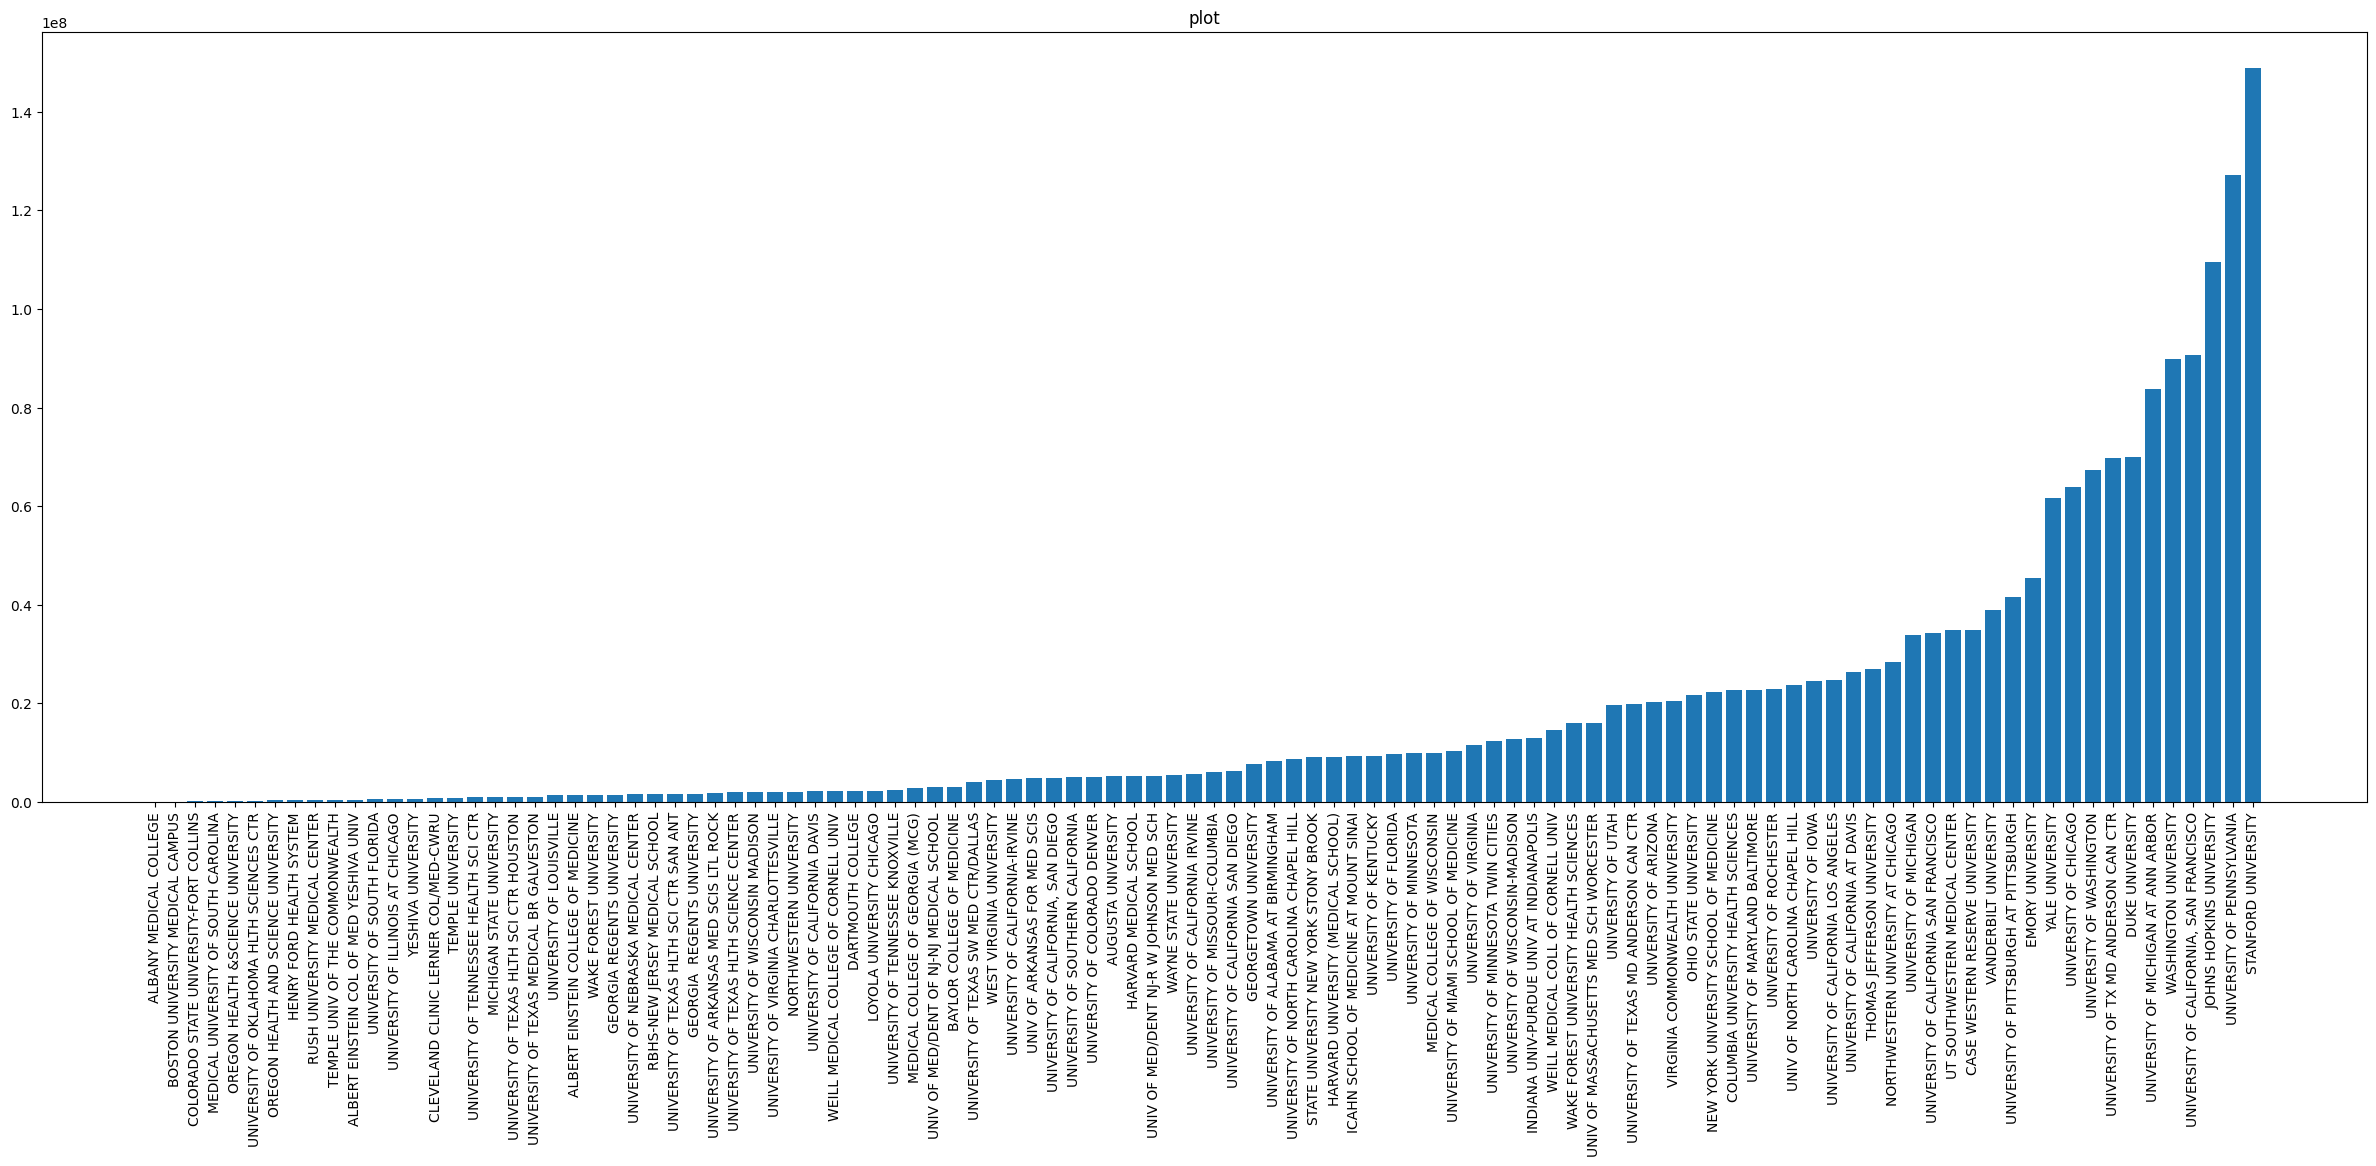

In [53]:
institutions = np.unique(data['ORG_NAME'])
total_cost = np.sum(data['TOTAL_COST'])
total_inst = []
fract_inst = []
for inst in institutions:
  total_inst.append(np.sum(data[data['ORG_NAME'] == inst]['TOTAL_COST']))
  fract_inst.append(np.sum(data[data['ORG_NAME'] == inst]['TOTAL_COST']) / total_cost)

order = np.argsort(total_inst, )
plt.figure(figsize=[30,10])
plt.bar(np.array(institutions)[order],np.array(total_inst)[order])
plt.xticks(rotation='vertical')
plt.title('plot')

print('cumsum of top 10 unis ' + str(np.sum(np.array(fract_inst)[order[-10:]])))
for i in range(10):
  print(institutions[order[-(i+1)]] + '     ' + str(fract_inst[order[-(i+1)]]))

#print(np.array(total_inst)[order])
#print(np.array(institutions)[order])

In [54]:
len(institutions)

106

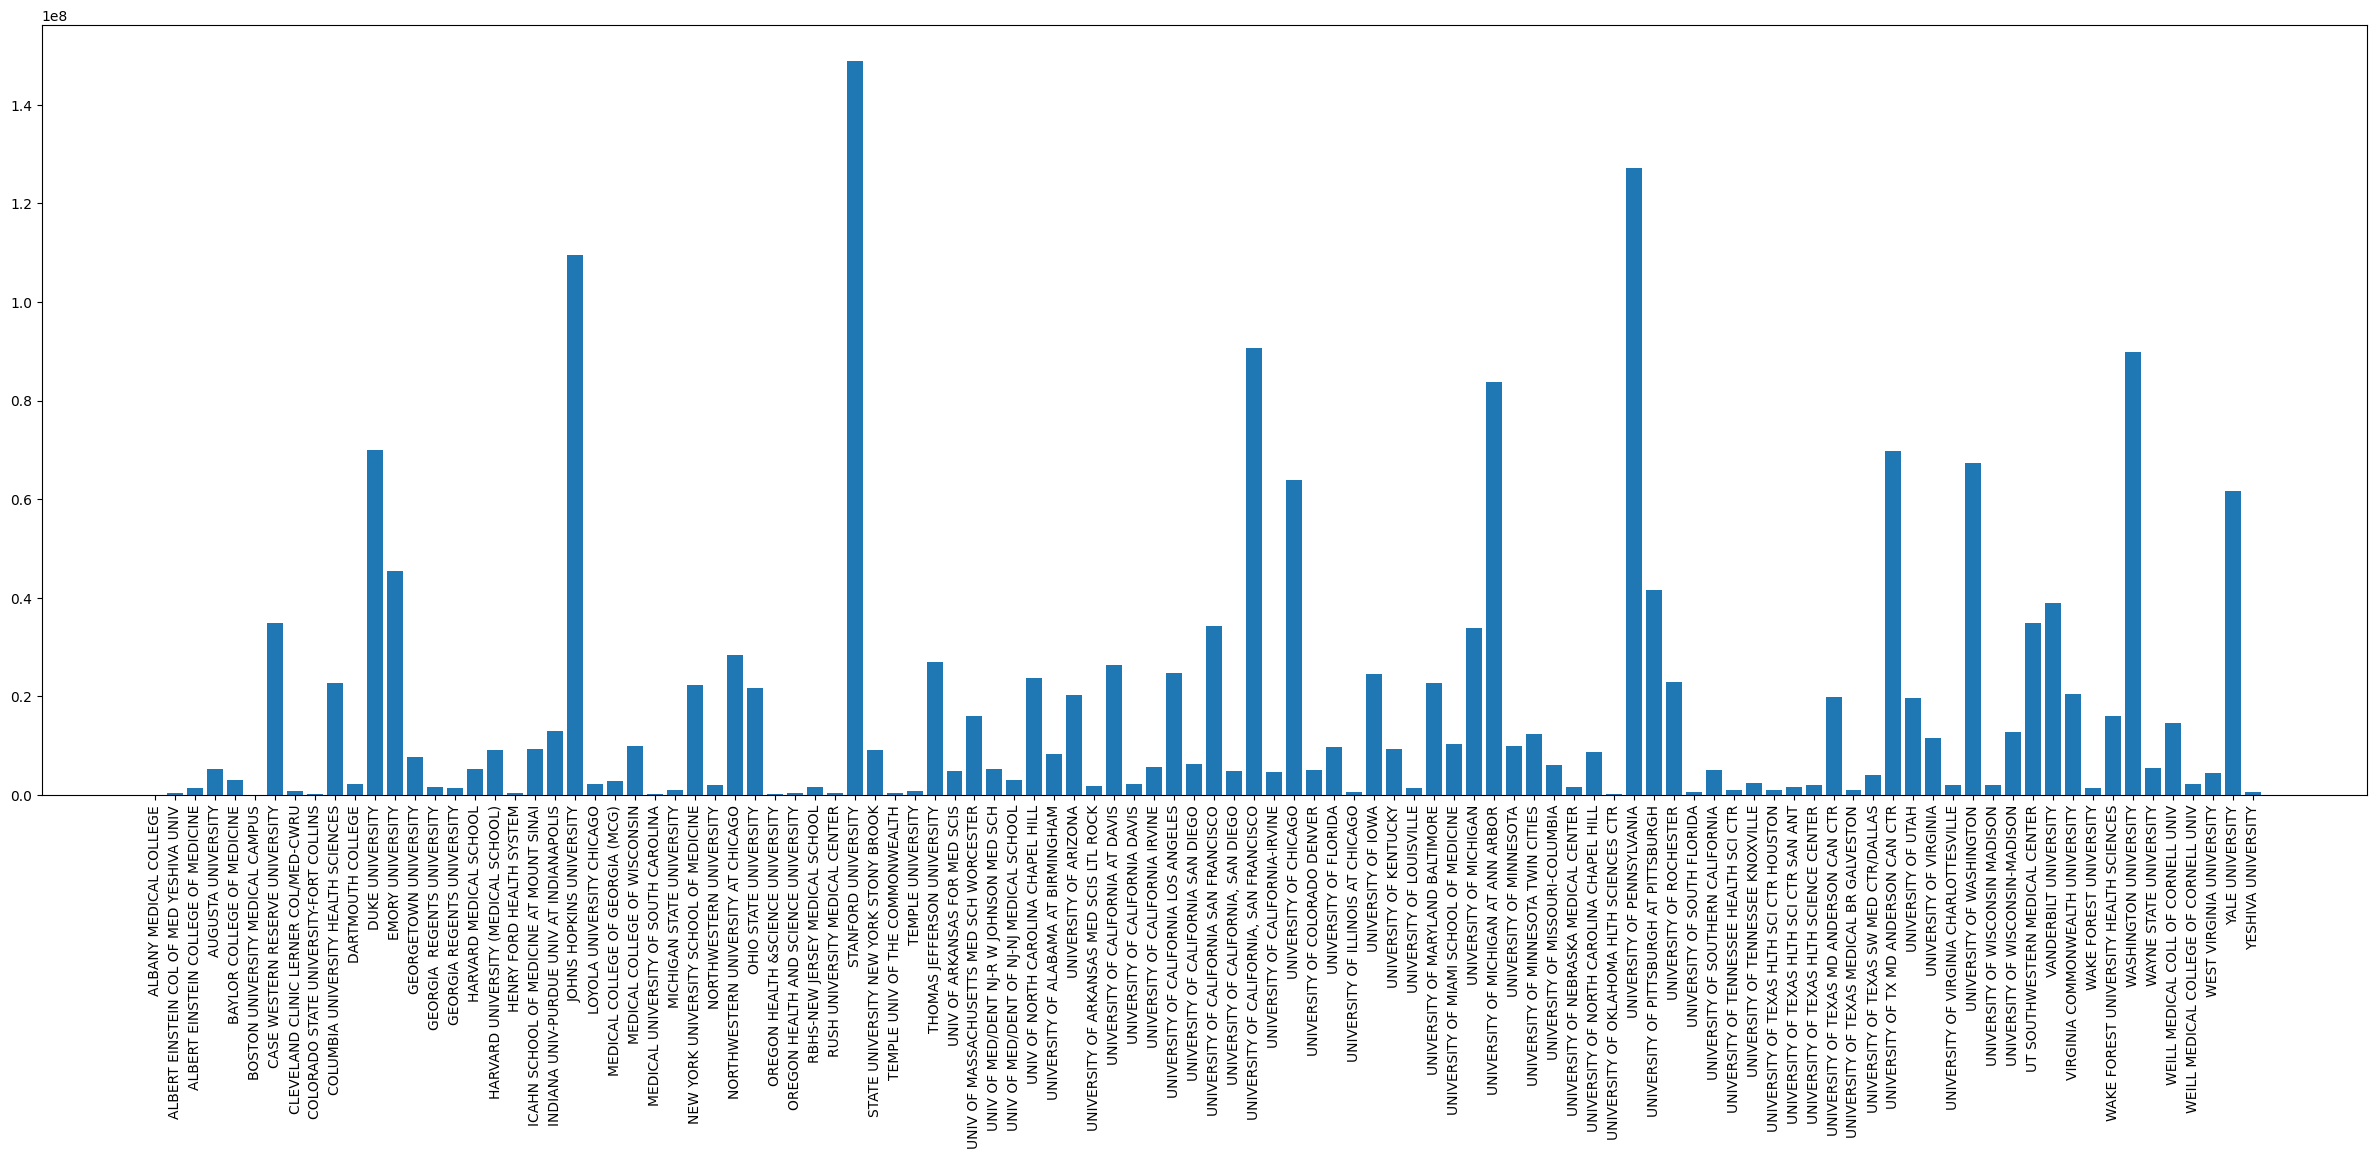

In [55]:
inst_size=[]
for inst in institutions:
  inst_size.append(np.sum(data[data['ORG_NAME'] == inst]['TOTAL_COST']))

plt.figure(figsize=[30,10])
plt.bar(institutions, inst_size)
plt.xticks(rotation='vertical')
plt.show()

# Validation

## Validation Data Export

### General


In [60]:
def get_centroids(text, clusters):
    
    tfidf_dense = pd.DataFrame(tfidf)
    tfidf_dense['cluster'] = clusters

    vocab = vectorizer.vocabulary_
    vocab = {v: k for k, v in vocab.items()} # reverses vocab to {index:word}
    
    centroids = np.zeros([len(np.unique(clusters)), len(vocab)+1])
    
    for i in np.unique(clusters):
        centroids[i, :] = np.mean(tfidf_dense[tfidf_dense['cluster'] == i])
    centroids = np.delete(centroids, -1, 1)
    
    return centroids, vocab

In [61]:
# Use either condensed_clusters or condensed_clusters_processed
def n_largest_ind(n, data):
    final_list = [] 
  
    for i in range(n):  
        max1 = 0
        ind1 = 0
          
        for j in range(len(data)):      
            if data[j] > max1: 
                max1 = data[j];
                ind1 = j
                  
        data[ind1] = 0 
        final_list.append(ind1) 
        
    return final_list

def get_cluster_terms(vocab, centroids, clusters):
    cluster_labels = np.unique(clusters)

    top_n = 10 # top n words from each cluster
    
    top_terms = np.zeros([len(cluster_labels), top_n])

    for i in cluster_labels:
        top_terms[i, :] = n_largest_ind(top_n, np.squeeze(centroids[i, :]))
        
    terms = []
    for i in top_terms:
        tmp = []
        for j in i:
            tmp.append(vocab.get(j))
        terms.append(tmp)

    out = pd.DataFrame()
    out['cluster'] = np.unique(clusters)
    out['terms'] = terms

    return out

In [62]:
centroids60, vocab = get_centroids(tfidf, clusters60)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

In [63]:
centroids, vocab = get_centroids(tfidf, clusters15)
out = get_cluster_terms(vocab, centroids, clusters15)
out['name'] = cluster_name
out

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

cluster                                              terms  \
0         0  [dose, imrt, system, ct, radiation, imaging, m...   
1         1  [dna, repair, damage, chromatin, instability, ...   
2         2  [imaging, pet, system, image, ct, treatment, d...   
3         3  [breast, mri, imaging, cancer, prostate, ultra...   
4         4  [tumor, peptide, cells, gene, labeled, cell, r...   
5         5  [imaging, tumor, mri, treatment, patients, can...   
6         6  [patients, pet, cancer, radiation, imaging, pr...   
7         7  [cells, cancer, radiation, tumor, breast, meta...   
8         8  [cells, cancer, cell, signaling, tumor, protei...   
9         9  [imaging, pdt, tumor, cancer, mri, tumors, liv...   
10       10  [p53, mdm2, brca1, bcl, apoptosis, cells, dna,...   
11       11  [tumor, cancer, cells, targeting, agents, ther...   
12       12  [breast, cad, mammography, screening, detectio...   
13       13  [tumor, imaging, tumors, mri, cancer, delivery...   
14       14  [cells, p53, cell, tumor, cancer, radiation, e...   

                                               name  
0   (60) Improving performance of breast cancer CAD  
1   (60) Improving performance of breast cancer CAD  
2   (60) Improving performance of breast cancer CAD  
3   (60) Improving performance of breast cancer CAD  
4   (60) Improving performance of breast cancer CAD  
5   (60) Improving performance of breast cancer CAD  
6   (60) Improving performance of breast cancer CAD  
7   (60) Improving performance of breast cancer CAD  
8   (60) Improving performance of breast cancer CAD  
9   (60) Improving performance of breast cancer CAD  
10  (60) Improving performance of breast cancer CAD  
11  (60) Improving performance of breast cancer CAD  
12  (60) Improving performance of breast cancer CAD  
13  (60) Improving performance of breast cancer CAD  
14  (60) Improving performance of breast cancer CAD

In [64]:
centroids60, vocab60 = get_centroids(tfidf, clusters60)
out60 = get_cluster_terms(vocab60, centroids60, clusters60)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

In [65]:
out60['name'] = cluster_name_dendrogram_60
out60

cluster                                              terms  \
0         0  [treatment, dose, radiation, system, planning,...   
1         1  [immune, radiation, brain, cells, tumor, lung,...   
2         2  [treatment, patients, cancer, imaging, clinica...   
3         3  [pdt, ablation, oxygen, imaging, light, prosta...   
4         4  [imaging, mri, tumor, treatment, patients, bre...   
5         5  [imaging, tumor, mri, thermal, tissue, heat, r...   
6         6  [tumor, cells, cancer, metastatic, cell, inhib...   
7         7  [psma, imaging, disease, prostate, targeting, ...   
8         8  [radiation, dose, lung, patients, treatment, t...   
9         9  [cancer, research, screening, survivors, lung,...   
10       10  [breast, screening, women, cad, cancer, detect...   
11       11  [p53, mdm2, brca1, cyclin, pten, breast, uv, r...   
12       12  [radiation, irradiation, cells, induced, brain...   
13       13  [pet, imaging, spect, reconstruction, photon, ...   
14       14  [radiation, instability, damage, bystander, dn...   
15       15  [tumor, mri, changes, tumors, brain, response,...   
16       16  [dna, repair, damage, checkpoint, chromatin, m...   
17       17  [dna, beta, repair, chromosome, brca1, replica...   
18       18  [mri, prostate, breast, imaging, ultrasound, c...   
19       19  [tumor, metastasis, hypoxia, cells, cancer, in...   
20       20  [methylation, epigenetic, genes, gene, express...   
21       21  [dose, imrt, proton, dosimetry, beam, distribu...   
22       22  [radiation, tumor, cells, cancer, rt, radiothe...   
23       23  [bcl, pdt, par, apoptosis, cells, cisplatin, c...   
24       24  [egfr, akt, ras, pi3k, signaling, pathway, veg...   
25       25  [ct, pet, breast, cbct, imaging, image, recons...   
26       26  [ct, breast, imaging, image, system, pet, imag...   
27       27  [ras, akt, lung, mtor, pi3k, nsclc, inhibition...   
28       28  [pet, fdg, patients, nsclc, tumor, response, r...   
29       29  [liver, pancreatic, lung, mri, ultrasound, can...   
30       30  [metastasis, cells, cancer, breast, tumor, met...   
31       31  [signaling, cells, expression, cell, tumorigen...   
32       32  [prostate, ultrasound, ablation, thermal, mri,...   
33       33  [13c, hp, metabolic, hyperpolarized, mrs, meta...   
34       34  [imaging, research, university, animal, pet, c...   
35       35  [cad, radiologists, computer, mammograms, perf...   
36       36  [gene, reporter, vectors, vector, living, expr...   
37       37  [tumor, peptide, labeled, antibody, receptor, ...   
38       38  [p53, apoptosis, e3, cell, ligase, hypoxia, su...   
39       39  [mri, imaging, mr, contrast, breast, diffusion...   
40       40  [dna, repair, peptide, residues, beta, cells, ...   
41       41  [imaging, system, resolution, ray, animal, sma...   
42       42  [compounds, cells, tumor, cell, cancer, molecu...   
43       43  [delivery, drug, tumor, cancer, nanoparticles,...   
44       44  [hypoxia, tumor, ef5, oxygen, po2, tumors, hyp...   
45       45  [motion, breathing, pet, dose, imrt, lung, ct,...   
46       46  [her2, imaging, prostate, psma, breast, pet, c...   
47       47  [dna, repair, dsb, nhej, dsbs, hr, atm, ir, te...   
48       48  [dna, repair, replication, cancer, genome, dam...   
49       49  [clinical, software, data, imaging, treatment,...   
50       50  [cancer, breast, tnbc, patients, risk, metasta...   
51       51  [18f, pet, imaging, hcc, 64cu, analogs, labele...   
52       52  [nodules, ct, lung, pulmonary, cad, detection,...   
53       53  [pet, tumor, imaging, uptake, 64cu, 18f, vivo,...   
54       54  [imaging, pdt, oxygen, optical, contrast, gd, ...   
55       55  [nanoparticles, imaging, delivery, vivo, drug,...   
56       56  [breast, risk, density, women, mammography, ca...   
57       57  [protein, cells, hypoxia, heat, radiation, apo...   
58       58  [dbt, tomosynthesis, breast, digital, mammogra...   
59       59  [mitochondrial, mnsod, cells, r

In [66]:
tempDF = pd.DataFrame()
tempDF['title'] = data['PROJECT_TITLE']
tempDF['abstract'] = data['Abstract']
tempDF['embedding'] = weighted_embedding
tempDF['clusters15'] = clusters15
tempDF['clusters60'] = clusters60

In [67]:
centroid60 = kmeans60.cluster_centers_

In [ ]:
df = pd.DataFrame()
centroid_range = len(centroid60)
top_n = 100
terms = []
c = []

for i in range(centroid_range):
    miniDF = tempDF[tempDF['clusters60'] == i]
    miniDF = miniDF.drop_duplicates(subset=['title']) #lower number of grants
    miniDF.reset_index(drop=True, inplace=True)

    embed = miniDF['embedding']
    d = np.linalg.norm(list(embed)-centroid60[i], axis=1)
    top_ind = np.argsort(d)[:top_n]
    df = df.append(miniDF.loc[top_ind, ['title', 'abstract']])
    terms += [out60['terms'][i]]*min(top_n, miniDF.shape[0])
    c += [i]*min(top_n, miniDF.shape[0])

df['Centroid'] = c
df['Centroid Terms'] = terms

df.to_excel('Centroids60_top_closest.xlsx')

In [ ]:
df = pd.DataFrame()
centroid_range = len(centroid15)
top_n = 10
terms = []
c = []

for i in range(centroid_range):
    miniDF = tempDF[tempDF['clusters15'] == i]
    miniDF = miniDF.drop_duplicates(subset=['title'])
    miniDF.reset_index(drop=True, inplace=True)

    embed = miniDF['embedding']
    d = np.linalg.norm(list(embed)-centroid15[i], axis=1)
    top_ind = np.argsort(d)[:top_n]
    df = df.append(miniDF.loc[top_ind, ['title', 'abstract']])
    terms += [out60['terms'][i]]*top_n
    c += [i]*top_n

df['Centroid'] = c
df['Centroid Terms'] = terms

# df.to_excel('Centroids60_top_closest.xlsx')

In [ ]:
df[df['Centroid']==1]

### Manual validation google form

In [ ]:
n_clusters = 60
n_choices = 4
n_points = 300
np.random.seed(0)

val_indices = np.random.choice(range(data.shape[0]), n_points, replace=False)
val_data = pd.DataFrame(columns=['Title', 'Abstract'])
A = []
B = []
C = []
D = []
E = []

correct_choices = []
for i, n in enumerate(val_indices):
    val_data.loc[i, 'Title'] = data.loc[n, 'PROJECT_TITLE']
    val_data.loc[i, 'Abstract'] = data.loc[n, 'Abstract']
    correct = int(data.loc[n, 'Cluster60'])
    correct_choices.append(correct)
    options = np.array(range(n_clusters))

    # can't pick the correct cluster
    options = np.delete(options, correct)
    options = np.random.choice(options, n_choices, replace=False)
    options = np.append(options, correct)

    # Shuffle options
    np.random.shuffle(options)

    A.append(', '.join(out60['terms'][options[0]]))
    B.append(', '.join(out60['terms'][options[1]]))
    C.append(', '.join(out60['terms'][options[2]]))
    D.append(', '.join(out60['terms'][options[3]]))
    E.append(', '.join(out60['terms'][options[4]]))

val_data['A'] = A
val_data['B'] = B
val_data['C'] = C
val_data['D'] = D
val_data['E'] = E

#Save val_data
val_data.to_excel('PRODUCTION_val_data2_60.xlsx')

#Save correct_choices
correct_choices=np.array(correct_choices)
np.savetxt('correct_choices_60.csv', correct_choices, delimiter=',')

val_data.head()

## Validation results

In [56]:
centroid15 = kmeans15.cluster_centers_
centroid60 = kmeans60.cluster_centers_

In [57]:
import csv

def import_answer(path):
    with open(path, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)

    ans = []
    for i in data:
        temp = float(i[0])
        ans.append(int(temp))

    return ans

In [58]:
questions15 = pd.read_excel('PRODUCTION_val_data2.xlsx')
questions60 = pd.read_excel('PRODUCTION_val_data2_60.xlsx')

correct15 = import_answer('correct_choices.csv')
correct60 = import_answer('correct_choices_60.csv')

In [68]:
cluster_dict15 = {}
cluster_dict15_inv = {}

for i in range(15):
    cluster_dict15[', '.join(out['terms'][i])] = i
    cluster_dict15_inv[i] = ', '.join(out['terms'][i])

cluster_dict60 = {}
cluster_dict60_inv = {}

for i in range(60):
    cluster_dict60[', '.join(out60['terms'][i])] = i
    cluster_dict60_inv[i] = ', '.join(out60['terms'][i])

In [69]:
sil_15 = []

sample_silhouette_values = metrics.silhouette_samples(weighted_embedding, clusters15)

for i in range(15):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clusters15 == i]

    sil_15.append(np.mean(ith_cluster_silhouette_values))

sil_60 = []

sample_silhouette_values = metrics.silhouette_samples(weighted_embedding, clusters60)

for i in range(60):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clusters60 == i]

    sil_60.append(np.mean(ith_cluster_silhouette_values))

In [70]:
def distance_from_centroid(title, centroid):
    for i, t in enumerate(data['PROJECT_TITLE']):
        if t == title:
            d_norm = np.linalg.norm(weighted_embedding[i] - centroid)
            d_cs = cosine_similarity([weighted_embedding[i]], [centroid])
            return d_norm, d_cs[0][0]

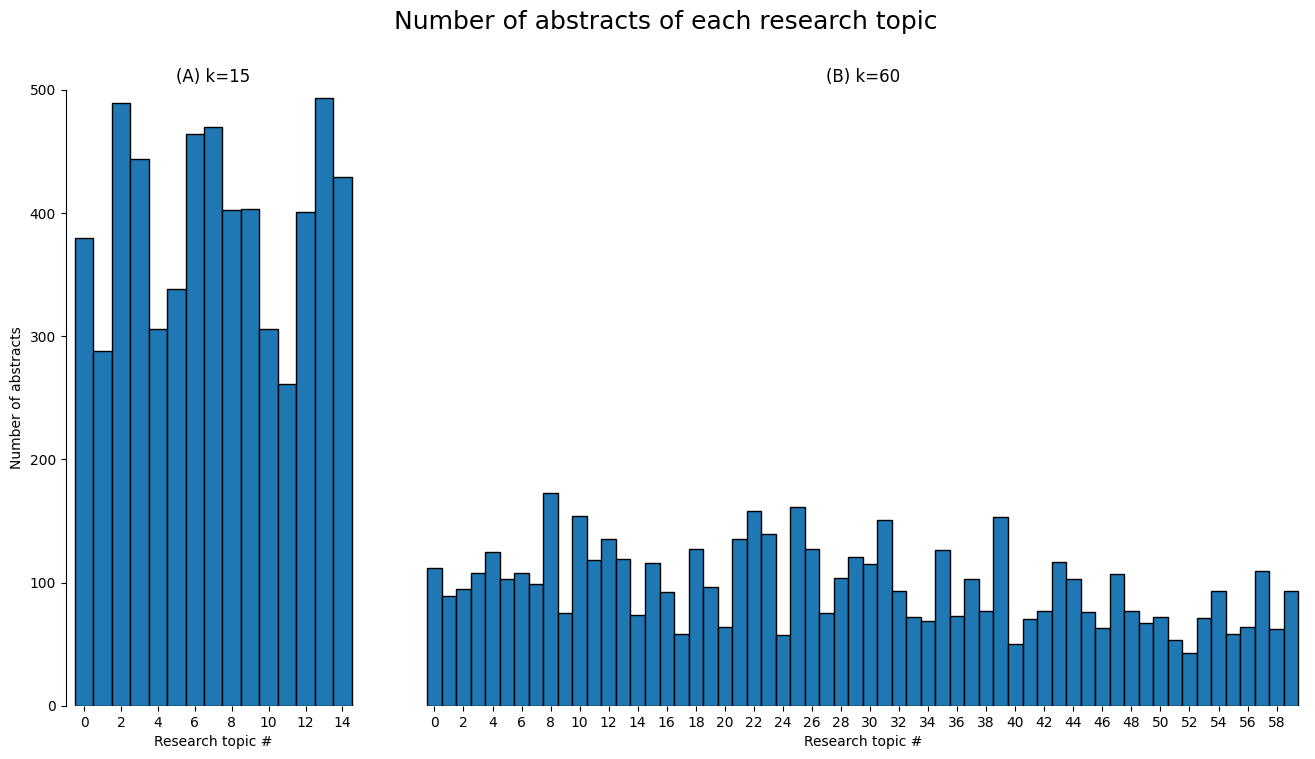

In [71]:
renumbering_15_dict = {i_c: f_c for i_c, f_c in zip(order15,list(range(15)))}
clusters15_renamed = [renumbering_15_dict[c] for c in clusters15]

renumbering_60_dict = {i_c: f_c for i_c, f_c in zip(order60,list(range(60)))}
clusters60_renamed = [renumbering_60_dict[c] for c in clusters60]

plt.figure(figsize=(16,8))
plt.suptitle('Number of abstracts of each research topic', fontsize=18)
gs = GridSpec(1, 2, width_ratios=[1,3], wspace=0.1)

ax0 = plt.subplot(gs[0,0])
ax0.set_title('(A) k=15')
bins_15 = np.arange(16) - 0.5
plt.hist(clusters15, bins=bins_15, ec='black')
plt.xticks(range(0,15,2))
plt.xlim([-1, 15])
plt.xlabel('Research topic #')

plt.ylim([0,500])
plt.ylabel('Number of abstracts')

for s in ['top','bottom','right']:
    ax0.spines[s].set_visible(False)

ax1 = plt.subplot(gs[0,1])
ax1.set_title('(B) k=60')
bins_60 = np.arange(61) - 0.5
plt.hist(clusters60, bins=bins_60, ec='black')
plt.xticks(range(0,60,2))
plt.xlim([-1, 60])
plt.xlabel('Research topic #')

plt.ylim([0,500])
plt.yticks([])
for s in ['top','bottom','right','left']:
    ax1.spines[s].set_visible(False)

plt.savefig('Number_of_abstracts.png', bbox_inches = "tight", dpi=720)

In [72]:
def find_distance(cs, d, reverse=True):
    cs_sorted = sorted(cs, reverse=reverse)
    for i in range(len(cs_sorted)):
        if cs_sorted[i] - d < 10**-6:
            return i

<ipython-input-73-ed5d853def23>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df = wrong_df.append(questions15.iloc[(i + ith_r*75)%300])
<ipython-input-73-ed5d853def23>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df = wrong_df.append(questions15.iloc[(i + ith_r*75)%300])
<ipython-input-73-ed5d853def23>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df = wrong_df.append(questions15.iloc[(i + ith_r*75)%300])
<ipython-input-73-ed5d853def23>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df = wrong_df.append(questions15.iloc[(i + ith_r*75)%300])
<ipython-input-73-ed5d853def23>:49: FutureWarning: The f

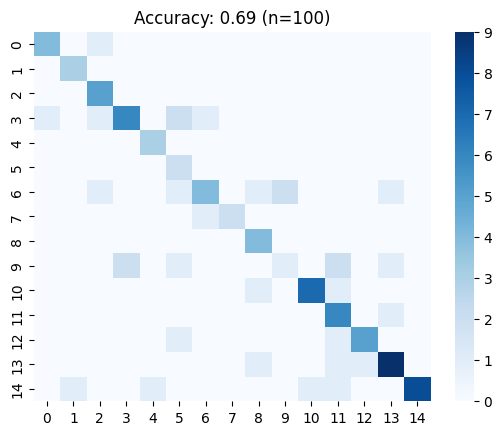

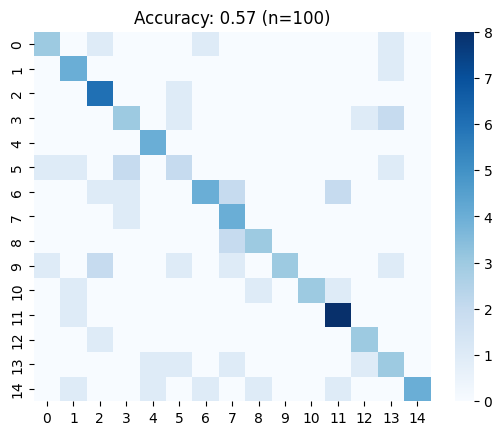

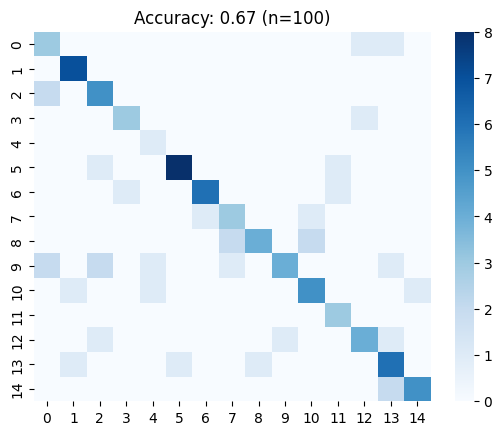

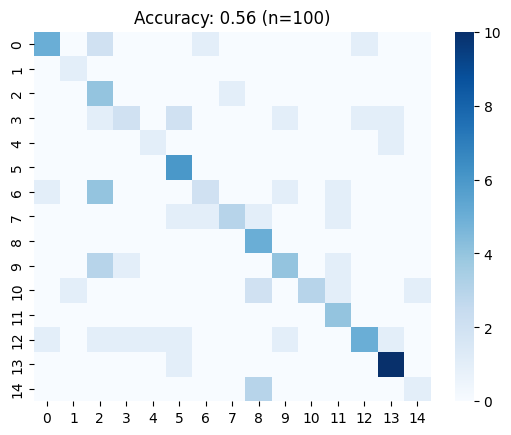

In [73]:
reviewer1 = pd.read_excel('Production Validation Data/Reviewer1 v2 (Responses).xlsx')
reviewer2 = pd.read_excel('Production Validation Data/Reviewer2 v2 (Responses).xlsx')
reviewer3 = pd.read_excel('Production Validation Data/Reviewer3 v2 (Responses).xlsx')
reviewer4 = pd.read_excel('Production Validation Data/Reviewer4 v2 (Responses).xlsx')

reviewers = [reviewer1, reviewer2, reviewer3, reviewer4]
wrong_df = pd.DataFrame(columns=questions15.keys())
cs = []
wrong_ans = []
right_ans = []
distance = []

d_norm_right_15 = []
d_norm_wrong_15 = []

d_cs_right_15 = []
d_cs_wrong_15 = []
ans_matrix_total_15 = np.zeros((15,15))

wrong_cs = []
selected_all = []

for ith_r, r in enumerate(reviewers):
    r = r.drop(columns=['Timestamp', 'Email Address'])
    r = r.T
    selected = []
    correct = []
    ans_matrix = np.zeros((15,15))
    count = 0

    for i, ans in enumerate(r[0]):
        if type(ans) != float:
            selected.append(cluster_dict15[ans])
            correct.append(correct15[(i + ith_r*75)%300])
        
            count += 1
            ans_matrix[correct[-1], selected[-1]] += 1
            ans_matrix_total_15[correct[-1], selected[-1]] += 1
            d_norm, d_cs = distance_from_centroid(questions15.iloc[(i+ith_r*75)%300]['Title'], 
                                                  centroid15[correct15[(i + ith_r*75)%300]])

            if selected[-1] != correct[-1]:

                temp_centroids = []

                for a in ['A', 'B', 'C', 'D', 'E']:
                    temp_centroids.append(centroid15[cluster_dict15[ questions15.iloc[(i + ith_r*75)%300][a] ]])
                
                wrong_df = wrong_df.append(questions15.iloc[(i + ith_r*75)%300])
                wrong_ans.append(cluster_dict15_inv[selected[-1]])
                right_ans.append(cluster_dict15_inv[correct[-1]])
                distance.append(np.squeeze(cosine_similarity([centroid15[correct[-1]]], [centroid15[selected[-1]]])))
                cs.append(np.squeeze(cosine_similarity([centroid15[correct[-1]]], temp_centroids)))    

                # wrong_cs.append(find_distance(cs[-1], distance[-1], True))

                d_norm_wrong_15.append(d_norm)
                d_cs_wrong_15.append(d_cs)
            else:
                d_norm_right_15.append(d_norm)
                d_cs_right_15.append(d_cs)

    selected_all.append(selected)
    accuracy = metrics.accuracy_score(selected, correct)
    plt.figure()
    sns.heatmap(ans_matrix, cmap="Blues")
    plt.title('Accuracy: ' + str(round(accuracy, 4)) + ' (n=' + str(count) + ')')

In [74]:
agreement1 = metrics.cohen_kappa_score(selected_all[0][-25:], selected_all[1][:25])
agreement2 = metrics.cohen_kappa_score(selected_all[1][-25:], selected_all[2][:25])
agreement3 = metrics.cohen_kappa_score(selected_all[2][-25:], selected_all[3][:25])
agreement4 = metrics.cohen_kappa_score(selected_all[3][-25:], selected_all[0][:25])

In [75]:
print(np.mean([agreement1, agreement2, agreement3, agreement4]))
print(np.std([agreement1, agreement2, agreement3, agreement4]))

0.6748905390951607
0.08661110039711829


Accuracy (n=400): 0.6225


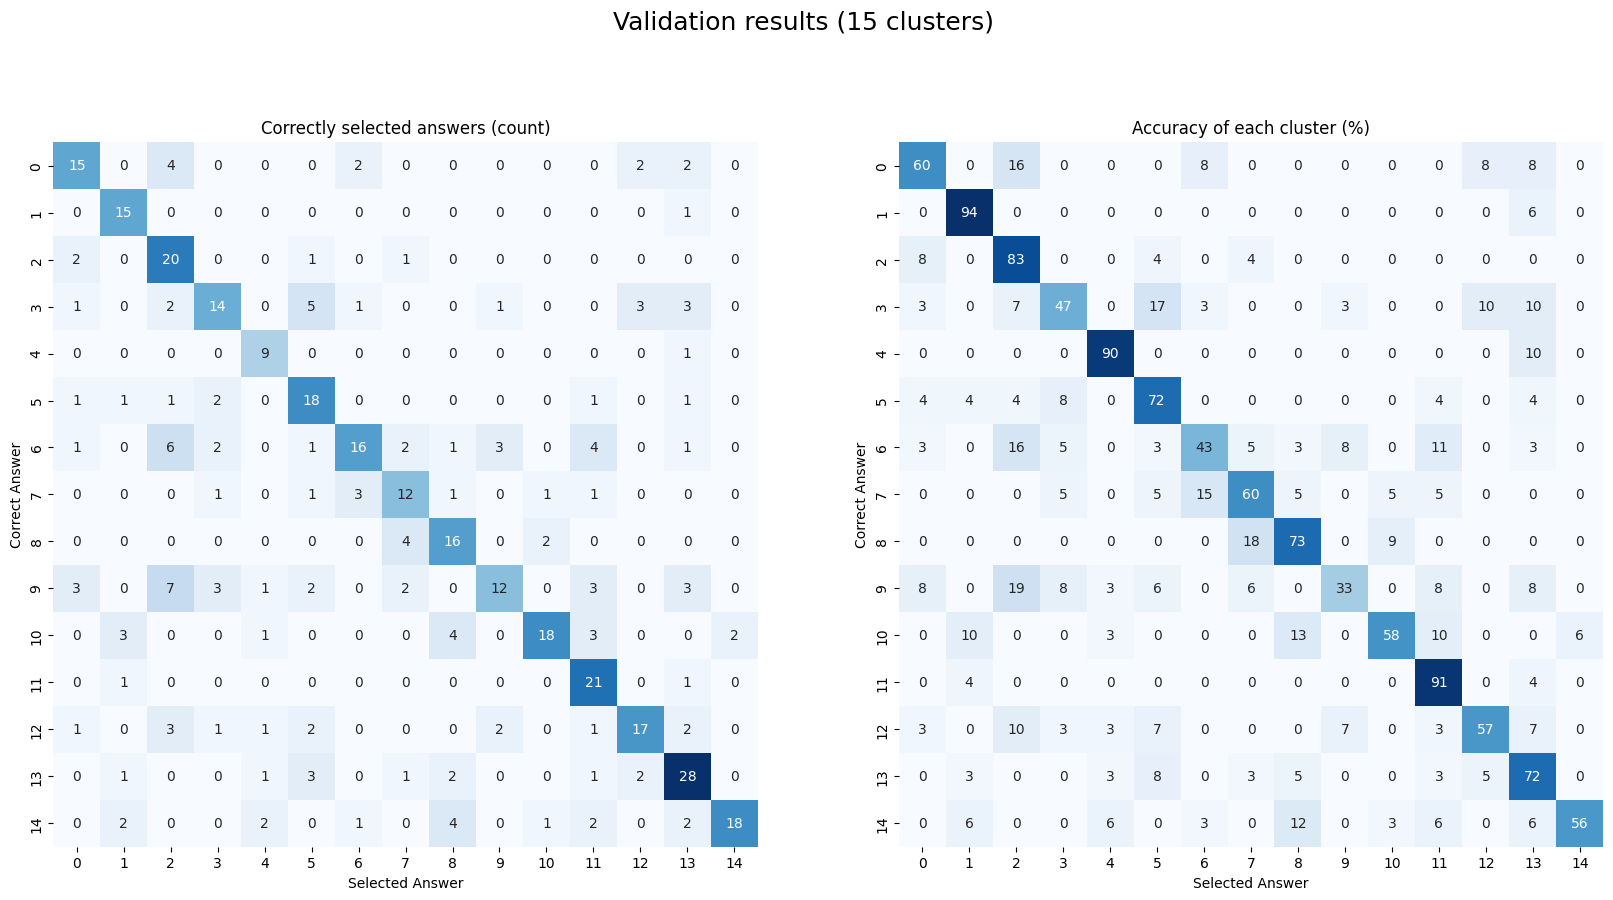

In [76]:
print('Accuracy (n=' + str(int(ans_matrix_total_15.sum())) + '):', 
      (np.diag(np.ones(15))*ans_matrix_total_15).sum() / ans_matrix_total_15.sum())

plt.figure(figsize=(20,10))
plt.suptitle('Validation results (15 clusters)', fontsize=18)
plt.subplot(1,2,1)
sns.heatmap(ans_matrix_total_15, cmap="Blues", annot=True, cbar=False, square=True)
plt.xlabel('Selected Answer')
plt.ylabel('Correct Answer')
plt.title('Correctly selected answers (count)')

plt.subplot(1,2,2)
ans_matrix_prob_15 = ans_matrix_total_15 / ans_matrix_total_15.sum(axis=1)[:,None]
ans_matrix_prob_15 = ans_matrix_prob_15 * 100
sns.heatmap(ans_matrix_prob_15, cmap="Blues", annot=True, fmt='.0f', cbar=False, square=True)
plt.xlabel('Selected Answer')
plt.ylabel('Correct Answer')
plt.title('Accuracy of each cluster (%)')

plt.savefig('Validation_Results_15.png')
plt.show()

In [84]:
from scipy.stats import ks_2samp

print(ks_2samp(d_norm_right_15, d_norm_wrong_15))
print(ks_2samp(d_cs_right_15, d_cs_wrong_15))

KstestResult(statistic=0.25402271337003646, pvalue=7.841660782549434e-06, statistic_location=6.405717215667921, statistic_sign=1)
KstestResult(statistic=0.3070028458203676, pvalue=2.431322358179337e-08, statistic_location=0.972957779255999, statistic_sign=-1)


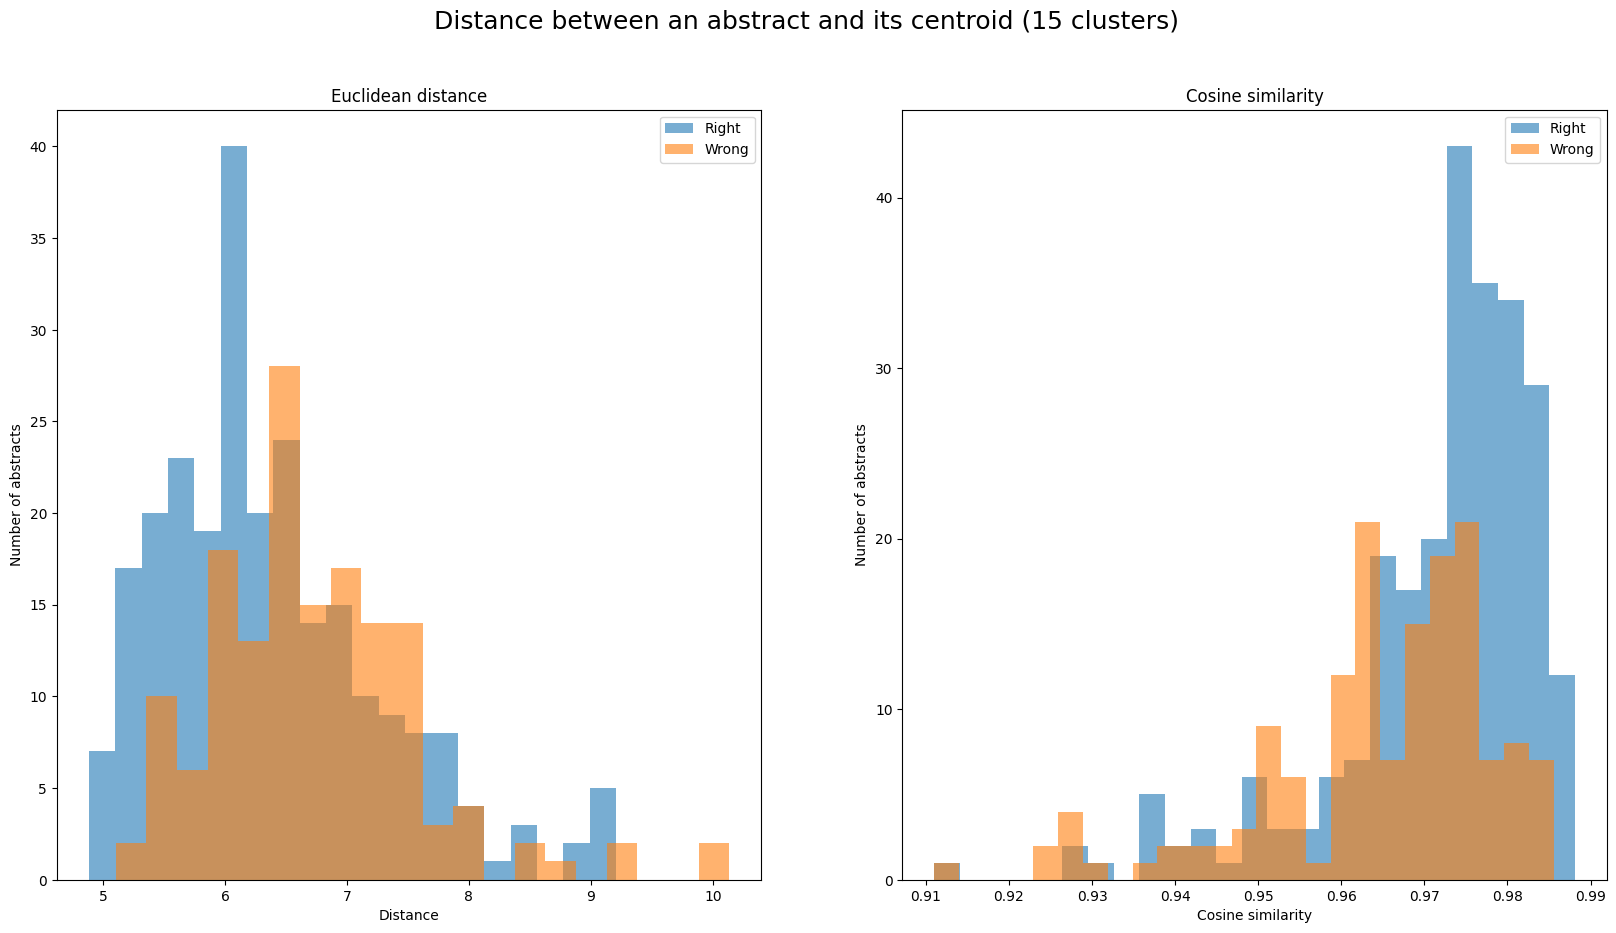

In [77]:
alpha = 0.6

plt.figure(figsize=(20,10))
plt.suptitle('Distance between an abstract and its centroid (15 clusters)', fontsize=18)
plt.subplot(1,2,1)
plt.hist(d_norm_right_15, bins=20, alpha=alpha)
plt.hist(d_norm_wrong_15, bins=20, alpha=alpha)
plt.xlabel('Distance')
plt.ylabel('Number of abstracts')
plt.title('Euclidean distance')
plt.legend(['Right', 'Wrong'])

plt.subplot(1,2,2)
plt.hist(d_cs_right_15, bins=25, alpha=alpha)
plt.hist(d_cs_wrong_15, bins=25, alpha=alpha)
plt.xlabel('Cosine similarity')
plt.ylabel('Number of abstracts')
plt.title('Cosine similarity')
plt.legend(['Right', 'Wrong'])

plt.savefig('Distance_15.jpeg')
plt.show()

<ipython-input-85-f60edad207b4>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df_60 = wrong_df_60.append(questions60.iloc[(i + ith_r*75)%300])
<ipython-input-85-f60edad207b4>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df_60 = wrong_df_60.append(questions60.iloc[(i + ith_r*75)%300])
<ipython-input-85-f60edad207b4>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df_60 = wrong_df_60.append(questions60.iloc[(i + ith_r*75)%300])
<ipython-input-85-f60edad207b4>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_df_60 = wrong_df_60.append(questions60.iloc[(i + ith_r*75)%300])
<ipython-input-85-f60edad207b4>:

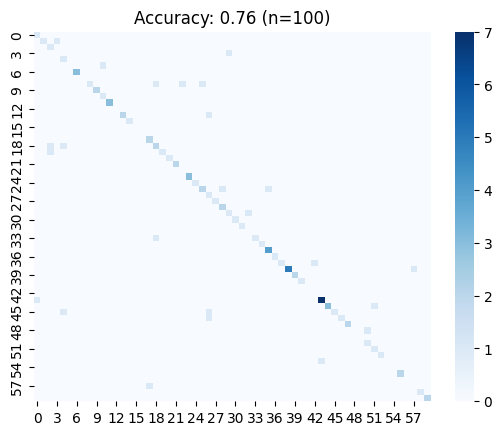

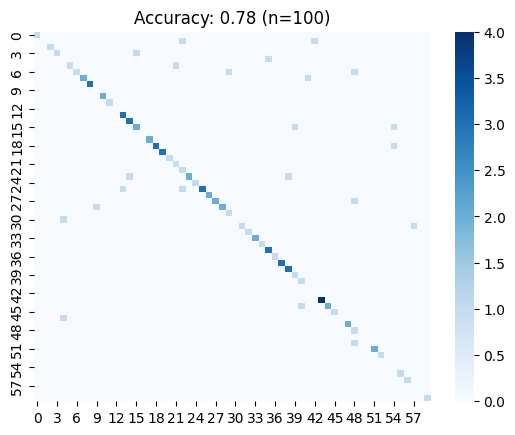

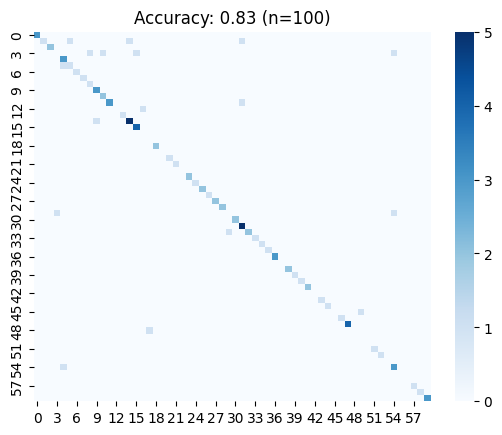

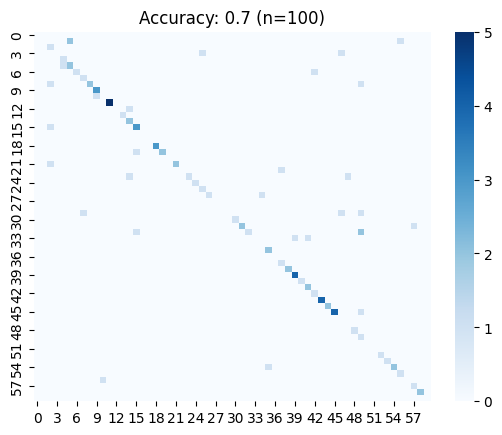

In [85]:
reviewer1_ = pd.read_excel('Production Validation Data/Reviewer 1 v2 (60 clusters) (Responses).xlsx')
reviewer2_ = pd.read_excel('Production Validation Data/Reviewer 2 v2 (60 clusters) (Responses).xlsx')
reviewer3_ = pd.read_excel('Production Validation Data/Reviewer 3 v2 (60 clusters) (Responses).xlsx')
reviewer4_ = pd.read_excel('Production Validation Data/Reviewer 4 v2 (60 clusters) (Responses).xlsx')

reviewers_ = [reviewer1_, reviewer2_, reviewer3_, reviewer4_]

wrong_df_60 = pd.DataFrame(columns=questions60.keys())
cs = []
wrong_ans = []
right_ans = []
distance = []

d_norm_right_60 = []
d_norm_wrong_60 = []

d_cs_right_60 = []
d_cs_wrong_60 = []

wrong_cs = []
ans_matrix_total_60 = np.zeros((60,60))

selected_all = []

for ith_r, r in enumerate(reviewers_):
    r = r.drop(columns=['Timestamp', 'Email Address'])
    r = r.T
    selected = []
    correct = []
    ans_matrix = np.zeros((60,60))
    count = 0

    for i, ans in enumerate(r[0]):
        if type(ans) != float:
            selected.append(cluster_dict60[ans])
            correct.append(correct60[(i + ith_r*75)%300])

            count += 1
            ans_matrix[correct[-1], selected[-1]] += 1
            ans_matrix_total_60[correct[-1], selected[-1]] += 1
            d_norm, d_cs = distance_from_centroid(questions15.iloc[(i+ith_r*75)%300]['Title'], 
                                                  centroid15[correct15[(i + ith_r*75)%300]])

            if selected[-1] != correct[-1]:

                temp_centroids = []

                for a in ['A', 'B', 'C', 'D', 'E']:
                    temp_centroids.append(centroid60[cluster_dict60[ questions60.iloc[(i + ith_r*75)%300][a] ]])
               
                wrong_df_60 = wrong_df_60.append(questions60.iloc[(i + ith_r*75)%300])
                wrong_ans.append(cluster_dict60_inv[selected[-1]])
                right_ans.append(cluster_dict60_inv[correct[-1]])
                distance.append(np.squeeze(cosine_similarity([centroid60[correct[-1]]], [centroid60[selected[-1]]])))
                cs.append(np.squeeze(cosine_similarity([centroid60[correct[-1]]], temp_centroids)))
                
                # wrong_cs.append(find_distance(cs[-1], distance[-1], True))

                d_norm_wrong_60.append(d_norm)
                d_cs_wrong_60.append(d_cs)
            else:
                d_norm_right_60.append(d_norm)
                d_cs_right_60.append(d_cs)

    selected_all.append(selected)
    accuracy = metrics.accuracy_score(selected, correct)
    plt.figure()
    sns.heatmap(ans_matrix, cmap="Blues")
    plt.title('Accuracy: ' + str(round(accuracy, 4)) + ' (n=' + str(count) + ')')

In [86]:
agreement1 = metrics.cohen_kappa_score(selected_all[0][-25:], selected_all[1][:25])
agreement2 = metrics.cohen_kappa_score(selected_all[1][-25:], selected_all[2][:25])
agreement3 = metrics.cohen_kappa_score(selected_all[2][-25:], selected_all[3][:25])
agreement4 = metrics.cohen_kappa_score(selected_all[3][-25:], selected_all[0][:25])

print(np.mean([agreement1, agreement2, agreement3, agreement4]))
print(np.std([agreement1, agreement2, agreement3, agreement4]))

0.705899751404125
0.06374927004813798


Accuracy (n=400): 0.7675


<ipython-input-87-4ffe763aa061>:14: RuntimeWarning: invalid value encountered in divide
  ans_matrix_prob_60 = ans_matrix_total_60 / ans_matrix_total_60.sum(axis=1)[:,None]


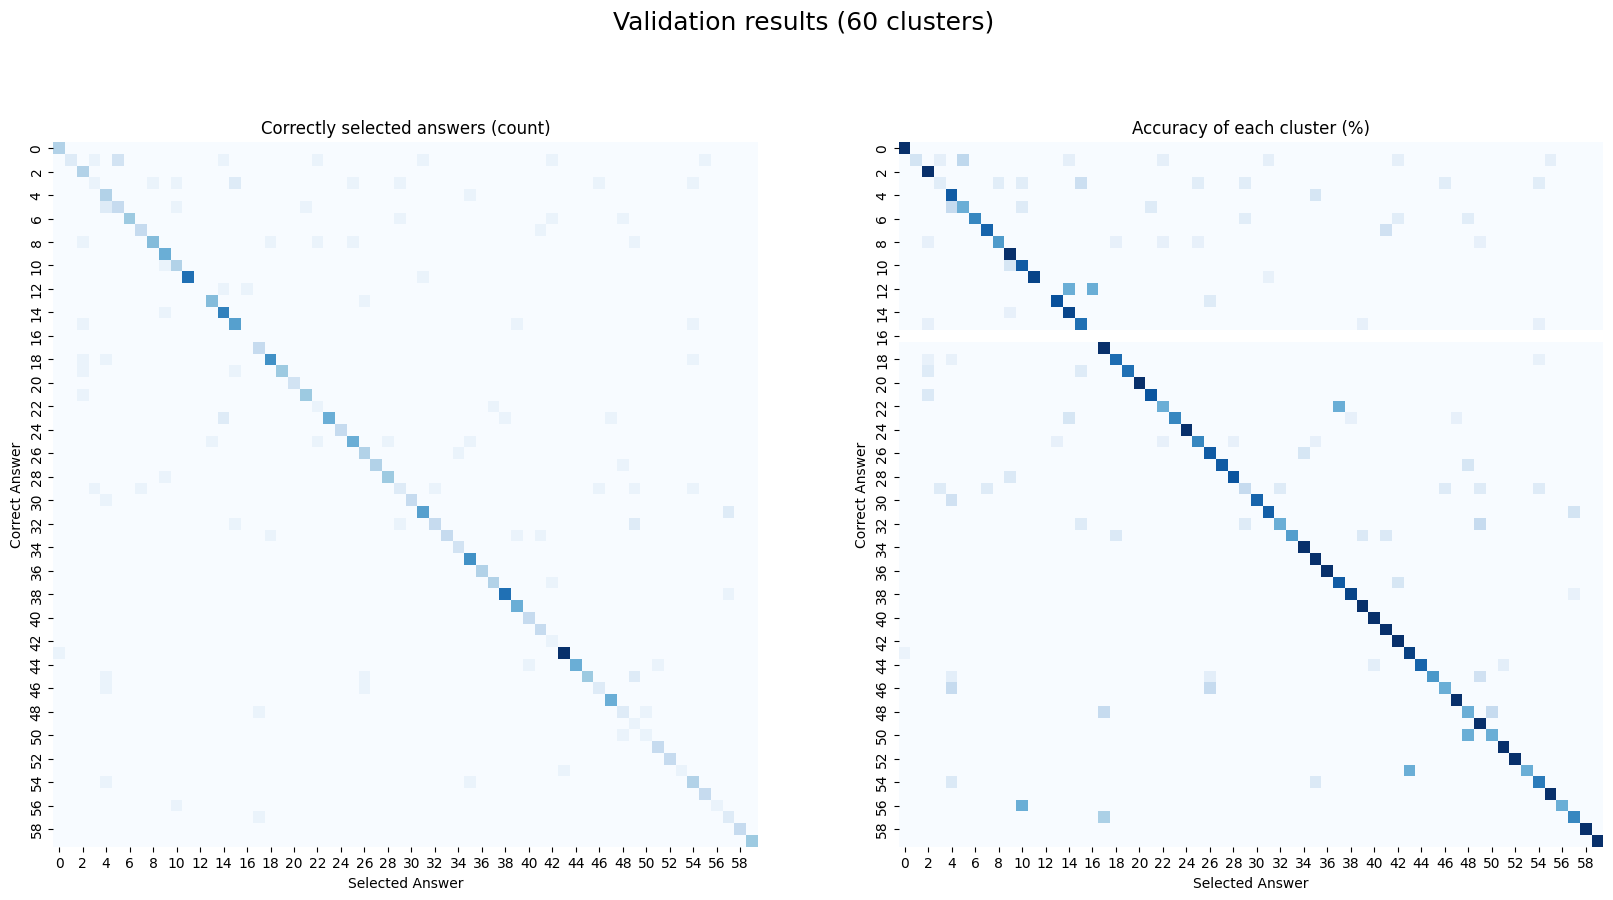

In [87]:
print('Accuracy (n=' + str(int(ans_matrix_total_60.sum())) + '):', 
      (np.diag(np.ones(60))*ans_matrix_total_60).sum() / ans_matrix_total_60.sum())

plt.figure(figsize=(20,10))
plt.suptitle('Validation results (60 clusters)', fontsize=18)

plt.subplot(1,2,1)
sns.heatmap(ans_matrix_total_60, cmap="Blues", square=True, cbar=False, annot_kws={'fontsize':'8'})
plt.xlabel('Selected Answer')
plt.ylabel('Correct Answer')
plt.title('Correctly selected answers (count)')

plt.subplot(1,2,2)
ans_matrix_prob_60 = ans_matrix_total_60 / ans_matrix_total_60.sum(axis=1)[:,None]
ans_matrix_prob_60 = ans_matrix_prob_60 * 100
sns.heatmap(ans_matrix_prob_60, cmap="Blues", square=True, cbar=False)
plt.xlabel('Selected Answer')
plt.ylabel('Correct Answer')
plt.title('Accuracy of each cluster (%)')

plt.savefig('Validation_Results_60.png')
plt.show()

In [89]:
print(ks_2samp(d_norm_right_60, d_norm_wrong_60))
print(ks_2samp(d_cs_right_60, d_cs_wrong_60))

KstestResult(statistic=0.09372701481559315, pvalue=0.5206807652068336, statistic_location=6.050251884201014, statistic_sign=1)
KstestResult(statistic=0.0842702532310602, pvalue=0.6533557372284412, statistic_location=0.9753490900958995, statistic_sign=-1)


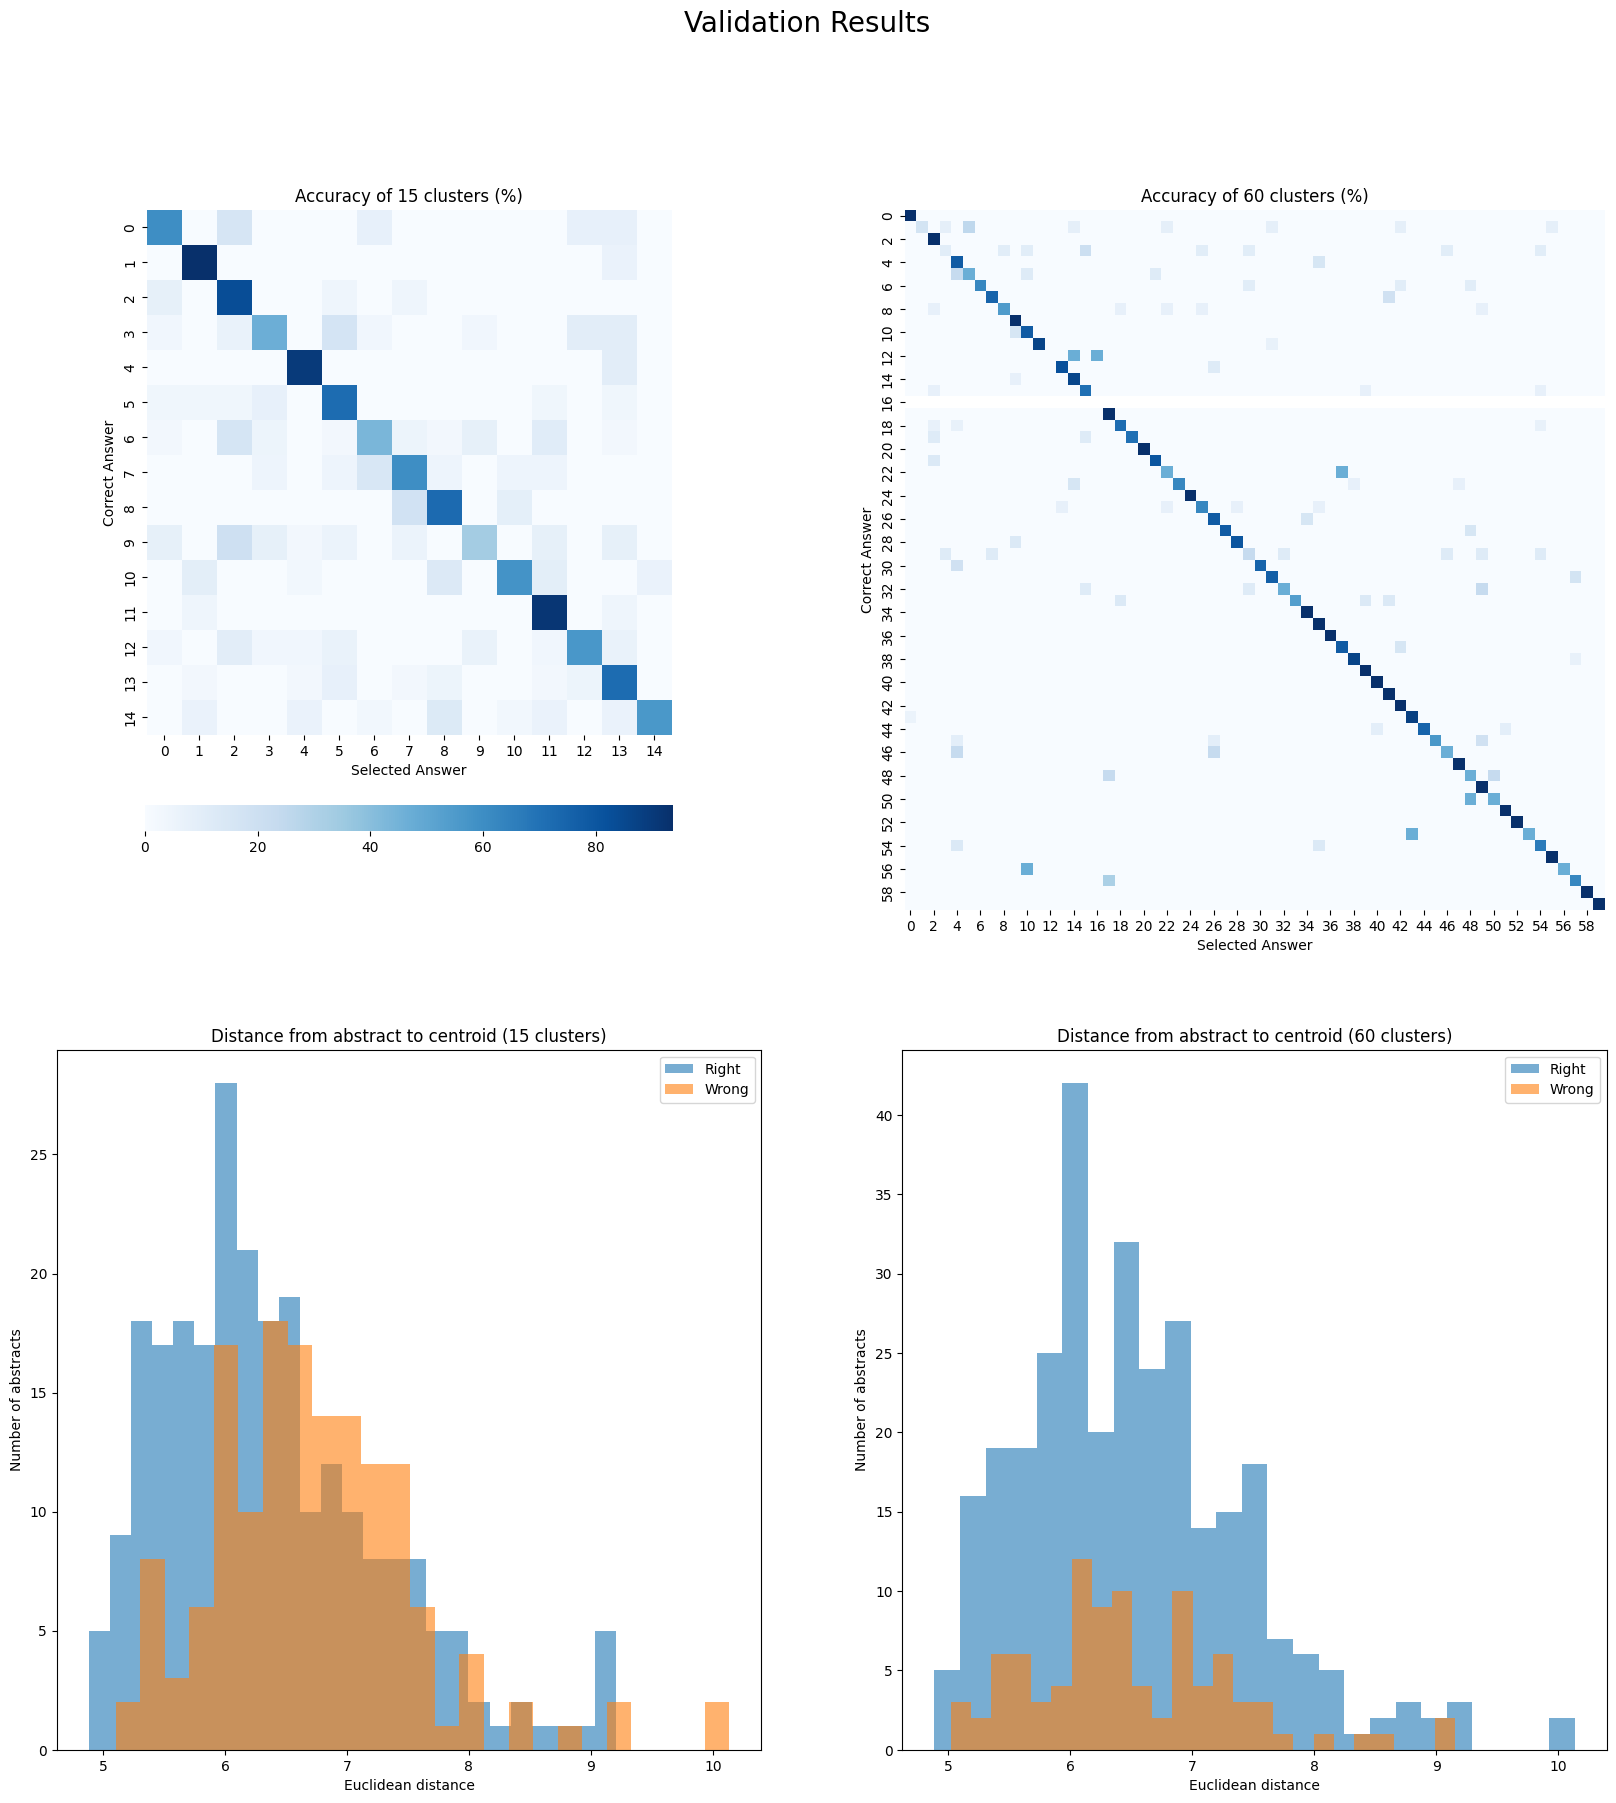

In [88]:
plt.figure(figsize=(20,20))
plt.suptitle('Validation Results', fontsize=20)

plt.subplot(2,2,1)
sns.heatmap(ans_matrix_prob_15, cmap="Blues", square=True, cbar_kws=dict(use_gridspec=False,location="bottom", pad=0.1, shrink=0.75))
plt.xlabel('Selected Answer')
plt.ylabel('Correct Answer')
plt.title('Accuracy of 15 clusters (%)')

plt.subplot(2,2,2)
sns.heatmap(ans_matrix_prob_60, cmap="Blues", square=True, cbar=False)
plt.xlabel('Selected Answer')
plt.ylabel('Correct Answer')
plt.title('Accuracy of 60 clusters (%)')

plt.subplot(2,2,3)
plt.hist(d_norm_right_15, bins=25, alpha=alpha)
plt.hist(d_norm_wrong_15, bins=25, alpha=alpha)
plt.xlabel('Euclidean distance')
plt.ylabel('Number of abstracts')
plt.title('Distance from abstract to centroid (15 clusters)')
plt.legend(['Right', 'Wrong'])

plt.subplot(2,2,4)
plt.hist(d_norm_right_60, bins=25, alpha=alpha)
plt.hist(d_norm_wrong_60, bins=25, alpha=alpha)
plt.xlabel('Euclidean distance')
plt.ylabel('Number of abstracts')
plt.title('Distance from abstract to centroid (60 clusters)')
plt.legend(['Right', 'Wrong'])

plt.savefig('Validation.png')

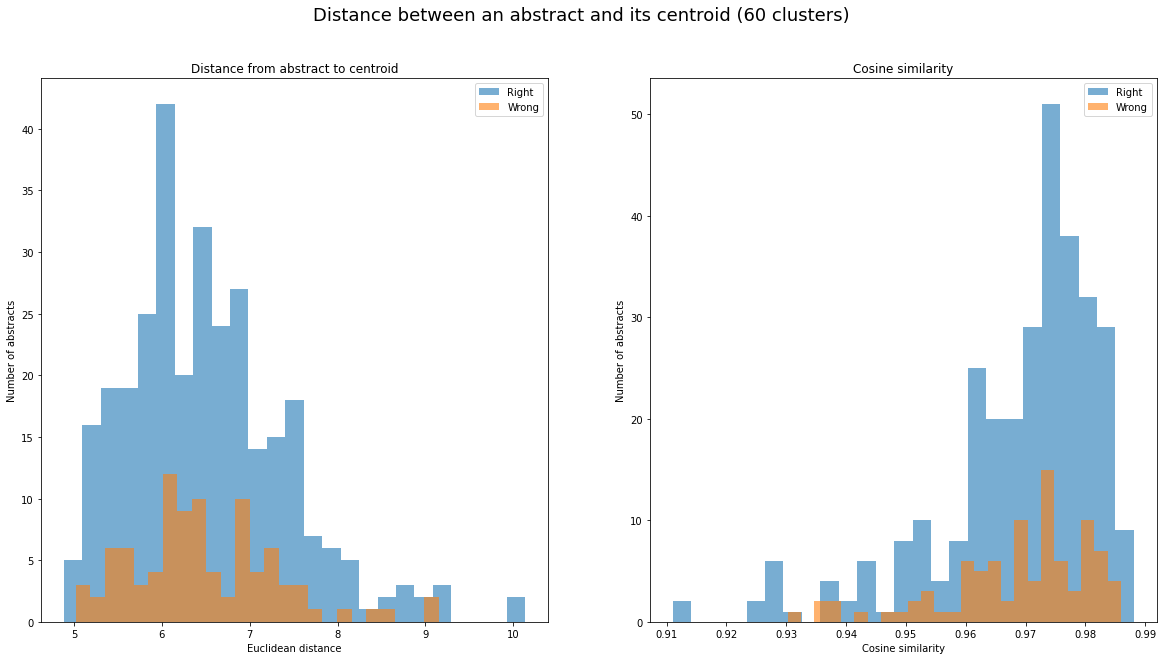

In [ ]:
alpha = 0.6

plt.figure(figsize=(20,10))
plt.suptitle('Distance between an abstract and its centroid (60 clusters)', fontsize=18)
plt.subplot(1,2,1)
plt.hist(d_norm_right_60, bins=25, alpha=alpha)
plt.hist(d_norm_wrong_60, bins=25, alpha=alpha)
plt.xlabel('Euclidean distance')
plt.ylabel('Number of abstracts')
plt.title('Distance from abstract to centroid')
plt.legend(['Right', 'Wrong'])

plt.subplot(1,2,2)
plt.hist(d_cs_right_60, bins=25, alpha=alpha)
plt.hist(d_cs_wrong_60, bins=25, alpha=alpha)
plt.xlabel('Cosine similarity')
plt.ylabel('Number of abstracts')
plt.title('Cosine similarity')
plt.legend(['Right', 'Wrong'])

plt.savefig('Distance_60.jpeg')
plt.show()

# Validate and Compare Combo Method

## Elbow Plot


In [ ]:
# Vanilla Elbow Plots

cluster_range = range(2, 75)

scores = []
for n_clusters in cluster_range:
  init = get_init(n_clusters, weighted_embedding)
  score_tmp = combo_cluster_1(n_clusters, init, weighted_embedding, return_scores = True)
  scores.append(score_tmp)

scores = np.array(scores)

Text(0, 0.5, 'Silhouette')

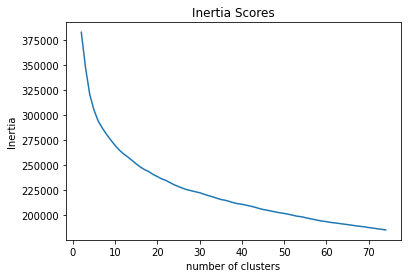

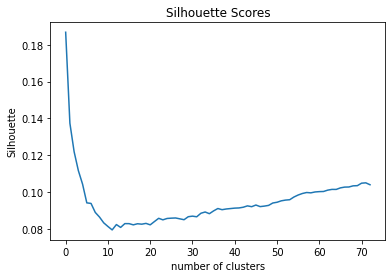

In [ ]:
plt.figure()
plt.plot(cluster_range, scores[:, 0])
plt.title('Inertia Scores')
plt.xlabel('number of clusters')
plt.ylabel('Inertia')

plt.figure()
plt.plot(scores[:, 1])
plt.title('Silhouette Scores')
plt.xlabel('number of clusters')
plt.ylabel('Silhouette')

In [ ]:
# Compare with Kmeans and Agglo 

combo_scores = scores[:, 1]

kmeans_scores = []
agglom_scores = []

for n_clusters in cluster_range:
  t = time.time()
  clusters = skc.KMeans(n_clusters = n_clusters, n_init=100).fit_predict(weighted_embedding)
  kmeans_scores.append(metrics.silhouette_score(weighted_embedding, clusters))
  print('n_clusters =', n_clusters, '| time =', time.time() - t)

  clusters = skc.AgglomerativeClustering(n_clusters = n_clusters).fit_predict(weighted_embedding)
  agglom_scores.append(metrics.silhouette_score(weighted_embedding, clusters))

plt.figure()
plt.plot(cluster_range, combo_scores)
plt.plot(cluster_range, kmeans_scores)
plt.plot(cluster_range, agglom_scores)
plt.legend(['Combo', 'KMeans', 'Agglomerative'])
plt.title('Combo vs. Established Algorithms')
plt.xlabel('')

## Consistency

In [ ]:
cluster_range = [15, 60]
n_runs = 5

lookin_good = True


for n_clusters in cluster_range:
  print(str(n_clusters) + ' Clusters: ')
  init = get_init(n_clusters, weighted_embedding)
  cluster1 = combo_cluster_1(n_clusters, init, weighted_embedding)
  for i in range(n_runs):
    clusters = combo_cluster_1(n_clusters, init, weighted_embedding)
    if np.array_equal(clusters, cluster1) == False:
      lookin_good = False
  if lookin_good:
    print('Lookin\' Good!')
  else:
    print('Not Lookin\' So Good')

# Stability

Run #: 1 / 100
Run #: 11 / 100
Run #: 21 / 100
Run #: 31 / 100
Run #: 41 / 100
Run #: 51 / 100
Run #: 61 / 100
Run #: 71 / 100
Run #: 81 / 100
Run #: 91 / 100
Number of Clusters: 15
mean: 0.5512933682483029
std: 0.06389344789447521


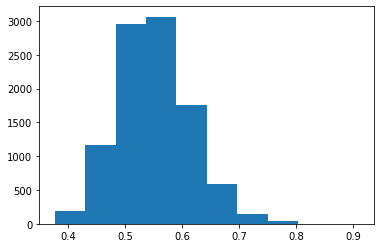

In [ ]:
# New version of stability
# This method removes 0.01 datapoints and generates duplicated datapoints

n_clusters = 15
n_runs = 100
n_samps = len(weighted_embedding)
n_replace = int(0.01 * n_samps)

embedding_array = np.array(weighted_embedding)


scores = []
clusters = []
for i in range(n_runs):
  if i%10 == 0:
      print('Run #:', i+1, '/', n_runs)
  subset = embedding_array
  indices_old = np.random.choice(range(n_samps), n_replace, replace = False)
  indices_new = np.random.choice(range(n_samps), n_replace, replace = False)
  
  for j, index in enumerate(indices_old):
    subset[index, :] = embedding_array[indices_new[j], :]

  init = get_init(n_clusters, subset)
  tmp, model = combo_cluster_1(n_clusters, init, subset, return_model=True)
  clusters.append(model.predict(weighted_embedding))
  
for i in range(n_runs):
  for j in range(n_runs):
    if i != j:
      scores.append(metrics.adjusted_rand_score(clusters[i], clusters[j]))
  
plt.hist(scores)
print('Number of Clusters: ' + str(n_clusters))
print('mean: ' + str(np.mean(scores)))
print('std: ' + str(np.std(scores)))

Run #: 1 / 100
Run #: 11 / 100
Run #: 21 / 100
Run #: 31 / 100
Run #: 41 / 100
Run #: 51 / 100
Run #: 61 / 100
Run #: 71 / 100
Run #: 81 / 100
Run #: 91 / 100
Number of Clusters: 60
mean: 0.4748564453450406
std: 0.03339963850597506


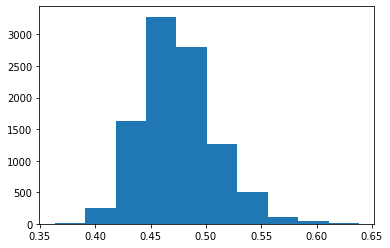

In [ ]:
# New version of stability
# This method removes 0.01 datapoints and generates duplicated datapoints

n_clusters = 60
n_runs = 100
n_samps = len(weighted_embedding)
n_replace = int(0.01 * n_samps)

embedding_array = np.array(weighted_embedding)


scores = []
clusters = []
for i in range(n_runs):
  if i%10 == 0:
    print('Run #:', i+1, '/', n_runs)
  subset = embedding_array
  indices_old = np.random.choice(range(n_samps), n_replace, replace = False)
  indices_new = np.random.choice(range(n_samps), n_replace, replace = False)
  
  for j, index in enumerate(indices_old):
    subset[index, :] = embedding_array[indices_new[j], :]

  init = get_init(n_clusters, subset)
  tmp, model = combo_cluster_1(n_clusters, init, subset, return_model=True)
  clusters.append(model.predict(weighted_embedding))
  
for i in range(n_runs):
  for j in range(n_runs):
    if i != j:
      scores.append(metrics.adjusted_rand_score(clusters[i], clusters[j]))
  
plt.hist(scores)
print('Number of Clusters: ' + str(n_clusters))
print('mean: ' + str(np.mean(scores)))
print('std: ' + str(np.std(scores)))

In [ ]:
# New version of stability
# This method removes 0.01 datapoints and generates duplicated datapoints

n_clusters = 15
n_runs = 100
n_samps = len(weighted_embedding)
n_replace = int(0.01 * n_samps)

embedding_array = np.array(weighted_embedding)


scores = []
clusters = []
for i in range(n_runs):
  if i%10 == 0:
      print('Run #:', i+1, '/', n_runs)
  subset = embedding_array
  indices_old = np.random.choice(range(n_samps), n_replace, replace = False)
  indices_new = np.random.choice(range(n_samps), n_replace, replace = False)
  
  for j, index in enumerate(indices_old):
    subset[index, :] = embedding_array[indices_new[j], :]

  init = get_init(n_clusters, subset)
  tmp, model = combo_cluster_1(n_clusters, init, subset, return_model=True)

  model = skc.KMeans(n_clusters=n_clusters, random_state=0)
  model = model.fit(weighted_embedding)
  clusters = model.predict(weighted_embedding)

  clusters.append(model.predict(weighted_embedding))
  
for i in range(n_runs):
  for j in range(n_runs):
    if i != j:
      scores.append(metrics.adjusted_rand_score(clusters[i], clusters[j]))
  
plt.hist(scores)
print('Number of Clusters: ' + str(n_clusters))
print('mean: ' + str(np.mean(scores)))
print('std: ' + str(np.std(scores)))

In [ ]:
# This version of stability doesn't consider index shifts due to removing points.

n_clusters = 60
n_runs = 100
n_samps = len(weighted_embedding)

embedding_array = np.array(weighted_embedding)


scores = []
clusters = []
for i in range(n_runs):

  indices = np.random.choice(range(n_samps), int(0.99 * n_samps), replace = False)
  subset = embedding_array[indices, :]

  init = get_init(n_clusters, subset)
  tmp, model = combo_cluster_1(n_clusters, init, subset, return_model=True)
  clusters.append(model.predict(weighted_embedding))
  
for i in range(n_runs):
  for j in range(n_runs):
    if i != j:
      scores.append(metrics.adjusted_rand_score(clusters[i], clusters[j]))
  
  
plt.hist(scores)
print('Number of Clusters: ' + str(n_clusters))
print('mean: ' + str(np.mean(scores)))
print('std: ' + str(np.std(scores)))

# Technical supplement

## TSNE & Silhouette Plots (Technical Supplement)


In [ ]:
def sil_breakdown(X, cluster_labels):
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    plt.figure(figsize=(15,15))

    n = len(np.unique(cluster_labels))

    palette = sns.hls_palette(n, l=.4, s=.9)

    for i in range(n):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        s = str(i) + ' - ' + str(np.round(np.mean(ith_cluster_silhouette_values),4))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=palette[i], edgecolor=palette[i], alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.1, y_lower + 0.5 * size_cluster_i, s)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("For n_clusters = " + str(n) + ". The average silhouette_score is : " + str(np.round(silhouette_avg, 4)))
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


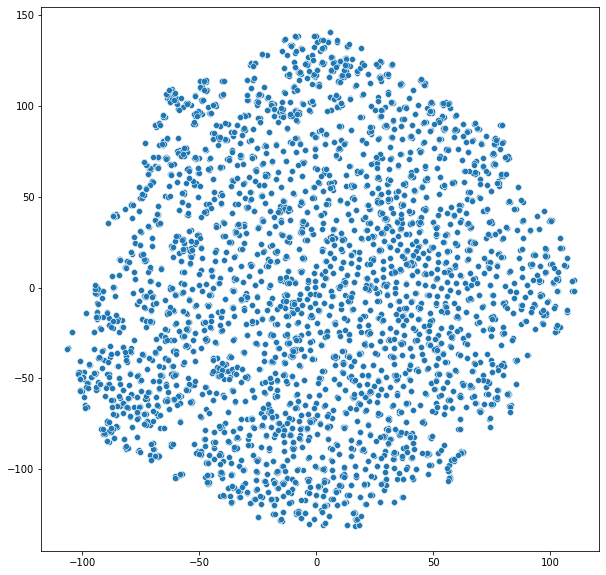

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


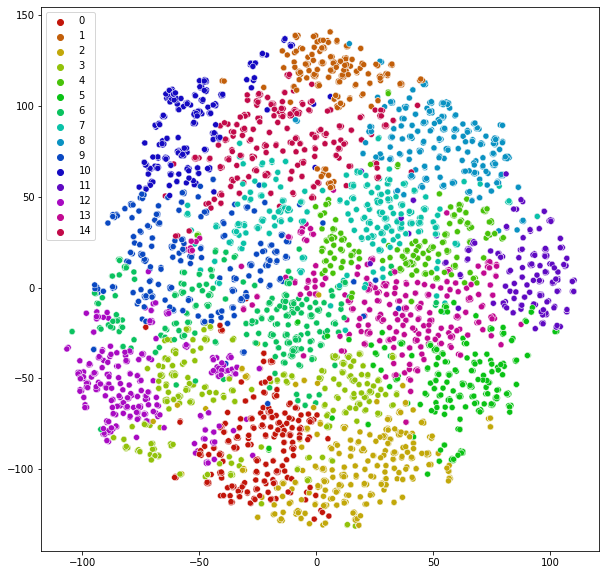

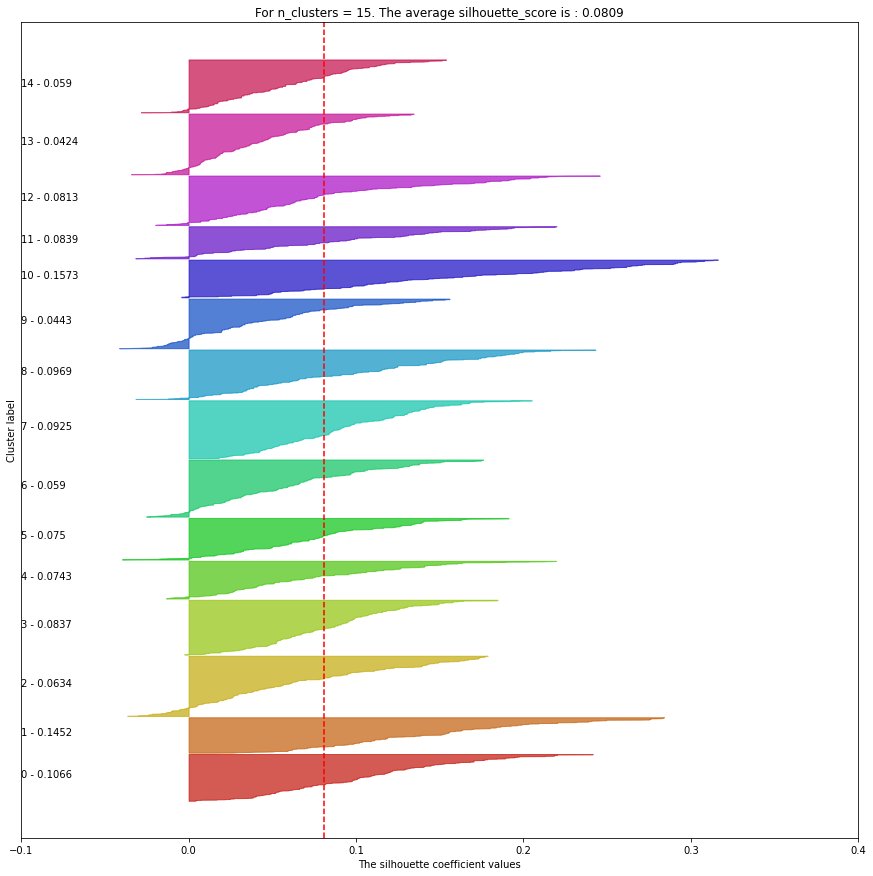

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


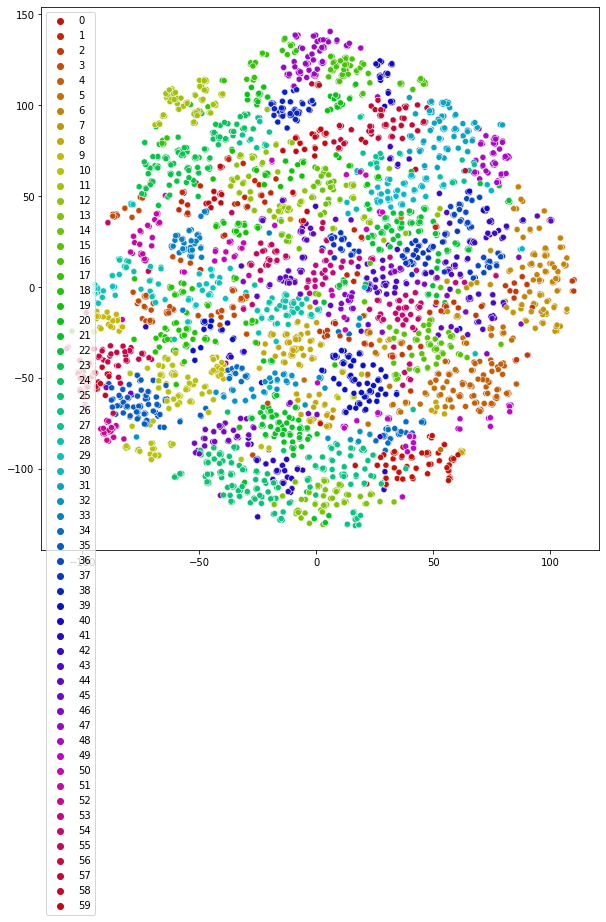

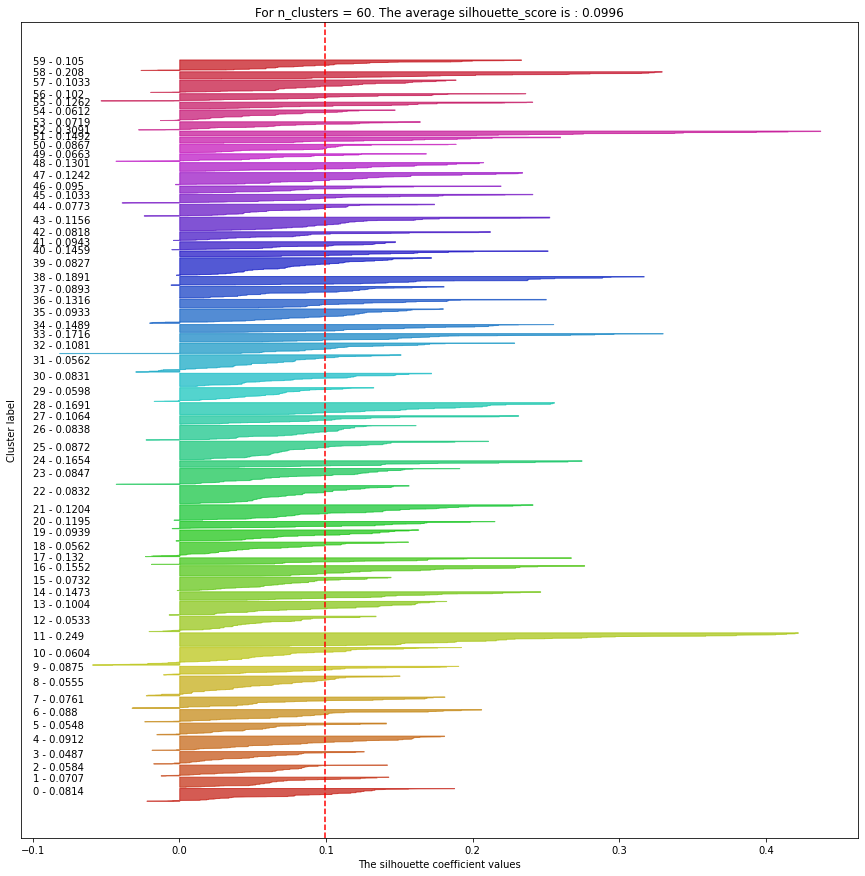

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets

cl_master = [clusters15, clusters60]
cluster_range = [15, 60]
tb = widgets.TabBar([str(0), str(15), str(60)])

with tb.output_to(0):
    plt.figure(figsize=(10,10))
    X_embedded = TSNE(random_state=0).fit_transform(weighted_embedding)
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1])

for i in range(2):
    with tb.output_to(i+1):
        cl = cl_master[i]

        plt.figure(figsize=(10,10))

        palette = sns.hls_palette(cluster_range[i], l=.4, s=.9)
        sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cl, legend='full', palette=palette)
        plt.legend()

        sil_breakdown(weighted_embedding, cl)

## TSNE hyperparameters

**perplexity** : float, default=30.0
    The perplexity is related to the number of nearest neighbors that:
is used in other manifold learning algorithms. Larger datasets
usually require a larger perplexity. Consider selecting a value
between 5 and 50. Different values can result in significantly
different results.

**early_exaggeration** : float, default=12.0
    Controls how tight natural clusters in the original space are in
the embedded space and how much space will be between them. For
larger values, the space between natural clusters will be larger
in the embedded space. Again, the choice of this parameter is not
very critical. If the cost function increases during initial
optimization, the early exaggeration factor or the learning rate
might be too high.

**learning_rate** : float or 'auto', default=200.0
    The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If
the learning rate is too high, the data may look like a 'ball' with any
point approximately equidistant from its nearest neighbours. If the
learning rate is too low, most points may look compressed in a dense
cloud with few outliers. If the cost function gets stuck in a bad local
minimum increasing the learning rate may help.

**n_iter** : int, default=1000
    Maximum number of iterations for the optimization. Should be at
least 250.

In [ ]:
X_embedded

array([[-24.867971  ,   1.9916775 ],
       [-11.841254  ,  68.57855   ],
       [ 40.280415  ,  -2.2665114 ],
       ...,
       [ 32.74685   ,  10.050534  ],
       [ 25.616146  ,  11.352883  ],
       [ 85.419174  ,   0.08951016]], dtype=float32)

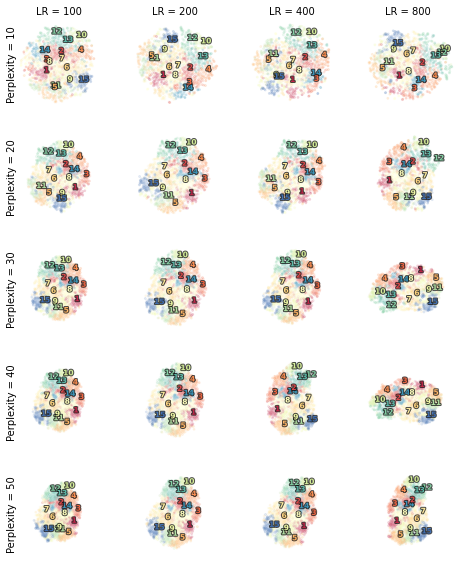

In [ ]:
n = len(np.unique(clusters15))
palette = sns.color_palette('Spectral', n)
perplexity_params = np.linspace(10,50,5, dtype=int)
lr_params = [100, 200, 400, 800]
plt.figure(figsize=(8,10))

for r, perplexity in enumerate(perplexity_params):
    for c, lr in enumerate(lr_params):
        ax = plt.subplot(5,4,r*4+c+1)

        X_embedded = TSNE(random_state=0, perplexity=perplexity, learning_rate=lr).fit_transform(weighted_embedding)
        for i in range(15):
            rank = int(re.search("(?<=\()(.*?)(?=\))", clusters15_remap[i]).group(1)) - 1
            col = [palette[rank]]*len(X_embedded[clusters15 == i, 0])
            plt.scatter(X_embedded[clusters15 == i, 0], X_embedded[clusters15 == i, 1], c=col, s=4, alpha=0.03)
            plt.text(np.mean(X_embedded[clusters15 == i, 0]), np.mean(X_embedded[clusters15 == i, 1]),
                    str(rank+1), fontsize=7.5, fontweight='bold', c=palette[rank], ma='center',
                    path_effects=[pe.withStroke(linewidth=2, foreground='k', alpha=0.7)])
        plt.xlim(-170,150)
        plt.ylim(-160,160)
        plt.axis('off')
        if r == 0: 
            plt.text(0,170,'LR = ' + str(lr),ha='center')
        if c == 0:
            plt.text(-170,0,'Perplexity = ' + str(perplexity), rotation='vertical', va='center')

plt.savefig('TSNE Hyperparams (k=15).png', bbox_inches = "tight")

## TSNE breakdown (Technical Supplement)

In [ ]:
plt.figure(figsize=(20,12))
for i in range(15):
    plt.subplot(3,5,i+1)
    col = [palette[i]]*len(X_embedded[clusters15 == i, :])
    plt.scatter(X_embedded[clusters15 == i, 0], X_embedded[clusters15 == i, 1], c=col, s=5)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1, alpha=0.1)
    plt.axis('off')
    plt.title('Cluster #' + str(i))

In [ ]:
plt.figure(figsize=(20,12))
for i in range(60):
    plt.subplot(6,10,i+1)
    col = [palette[i]]*len(X_embedded[clusters60 == i, :])
    plt.scatter(X_embedded[clusters60 == i, 0], X_embedded[clusters60 == i, 1], c=col, s=5)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=0.5, alpha=0.1)
    plt.axis('off')
    plt.title('Cluster #' + str(i))